# Prepare Environment

In [ ]:
# Install required libraries
!pip install -U kaleido # for saving graphs

In [ ]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade plotly>=6.1.1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import plotly.io as pio
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
from tensorflow.keras import backend as K

# Useful Functions

In [ ]:
# @title Filling missing values

def fill_missing_dates(df, date_column='date'):
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column).sort_index()

    # Reindex to continuous daily frequency
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_range)

    # interpolate missing values
    df.interpolate(method='linear', inplace=True)

    # Rename the index for clarity (optional)
    df.index.name = date_column

    return df


In [ ]:
# @title Defining create_sequences (for single feature) function
def create_sequences(data, window_size=30, horizon=30): # window_size=30: Use last 30 days of data as input/horizon=30: Predict the price 30 day into the future
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    return np.array(X), np.array(y)

In [ ]:
# @title Defining create_sequences_multifeature function and inverse

def create_sequences_multifeature(data, window_size=30, horizon=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1][0])  # <== ONLY take the first feature (TTF_Price)
    return np.array(X), np.array(y)


def inverse_single_feature(scaler, y_scaled, feature_index=0, total_features=3):
    """
    Inverse transform a single target feature from a scaler trained on multiple features.

    Parameters:
    - scaler: the fitted MinMaxScaler or StandardScaler
    - y_scaled: 1D array of scaled target values
    - feature_index: index of the feature to place into the dummy matrix (default: 0)
    - total_features: number of features originally fit in scaler

    Returns:
    - 1D array of inverse-transformed values
    """
    y_scaled = np.asarray(y_scaled).flatten()  # ✅ works with both NumPy and TensorFlow
    dummy = np.zeros((len(y_scaled), total_features))
    dummy[:, feature_index] = y_scaled
    return scaler.inverse_transform(dummy)[:, feature_index]

In [ ]:
# Path to saved results
results_path = '/content/drive/MyDrive/BKW/reports/test_results_TTF_LSTM_model_2.csv'

if os.path.exists(results_path):
    results_df2 = pd.read_csv(results_path)
    if 'features' not in results_df.columns:
        results_df['features'] = np.nan  # add column if missing
else:
    results_df2 = pd.DataFrame(columns=['Label', 'MAE', 'MSE', 'RMSE', 'R2', 'cutoff_date', 'features'])

In [ ]:
# @title Defining an model evalutation function
def evaluation_metrics(y_true, y_pred, label='', cutoff_date=None, features=None, results_df=None, save_path=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{label:<30} | MAE: {mae:>6.3f}  MSE: {mse:>6.3f}  RMSE: {rmse:>6.3f}  R²: {r2:>6.3f}")

    # Check for existing entry to avoid duplicates
    if results_df is not None:
        exists = ((results_df['Label'] == label) & (results_df['cutoff_date'] == str(cutoff_date))).any()
        if not exists:
            features_str = ', '.join(features) if isinstance(features, list) else str(features)
            results_df.loc[len(results_df)] = [label, mae, mse, rmse, r2, cutoff_date, features_str]
            if save_path:
                results_df.to_csv(save_path, index=False)

    return results_df

In [ ]:
# @title Defining a plotting function for the traning history
def plot_loss(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# @title Defining a plotting function to plot the historical data, actual and predicted price on the forecasting date
def plot_lstm_forecast_aligned_to_forecast_date(
    df_all,
    forecast_dates,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    title='Price Forecast (Aligned to Forecast Date)',
    save_path=None,   # e.g., '/content/drive/My Drive/BKW/reports'
    save_format='png' # 'png', 'pdf', 'svg', etc. (requires kaleido)
):
    """
    Plots historical  prices, and shows predicted & actual target prices on the forecast date.

    Parameters:
    - df_all: DataFrame with 'TTF_Price' and datetime index (historical)
    - forecast_dates: dates when forecasts were made
    - y_pred_inv: predicted prices for target dates (already inverse-transformed)
    - y_true_inv: actual target prices (already inverse-transformed)
    - horizon_days: how far ahead the forecast is (e.g., 30 for 1-month)
    - title: chart title
    - save_path: full file path to save the plot (optional)
    - save_format: file format (default 'png')

    Returns:
    - fig: the plotly figure object
    """

    # Convert inputs to pandas Series for indexing
    forecast_dates = pd.to_datetime(forecast_dates)
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)

    # Shift actual target values back to the forecast date
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')  # move back to forecast date

    # Start building the plot
    fig = go.Figure()

    # Historical TTF price
    fig.add_trace(go.Scatter(
        x=df_all.index,
        y=df_all['TTF_Price'],
        mode='lines',
        name='Historical Price',
        line=dict(color='lightgray'),
        opacity=0.5
    ))

    # Predicted target prices (plotted on forecast date)
    fig.add_trace(go.Scatter(
        x=y_pred_series.index,
        y=y_pred_series.values,
        mode='lines+markers',
        name=f'Predicted price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='orange')
    ))

    # Actual future prices aligned to forecast date
    fig.add_trace(go.Scatter(
        x=y_true_aligned.index,
        y=y_true_aligned.values,
        mode='lines+markers',
        name=f'Actual price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='blue')
    ))

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title='Forecast Date',
        yaxis_title='TTF_Price (EUR/MWh)',
        hovermode='x unified',
        xaxis=dict(tickangle=-45),
        height=600
    )

    fig.show()

    # Optionally save the plot
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.write_image(save_path, format=save_format)
        print(f"✅ Plot saved to: {save_path}")

    return fig

In [ ]:
#@title Function to Save Model and Training History
import os
import pickle

def save_model_and_history(model, history, save_dir, model_name='lstm_model'):
    """
    Saves a Keras model and its training history to the specified directory.

    Parameters:
    - model: trained Keras model
    - history: result of model.fit()
    - save_dir: directory path (e.g., '/content/drive/My Drive/LNG_Forecasts/')
    - model_name: base name for saved files (default: 'lstm_model')
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model.save(model_path)

    # Save history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✅ Model saved to: {model_path}")
    print(f"✅ History saved to: {history_path}")

In [ ]:
#@title Function to Load Model and Training History
from tensorflow.keras.models import load_model

def load_model_and_history(save_dir, model_name='lstm_model'):
    """
    Loads a saved Keras model and its training history.

    Parameters:
    - save_dir: directory path
    - model_name: base name used when saving

    Returns:
    - model: loaded Keras model
    - history: training history (as a dict)
    """
    # Load model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model = load_model(model_path)

    # Load history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    print(f"✅ Model loaded from: {model_path}")
    print(f"✅ History loaded from: {history_path}")
    return model, history

In [ ]:
# @title Defining a function to save the forecast results
def save_lstm_forecast_results_full(
    forecast_dates,
    features_df,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    save_path=None
):
    """
    Adds predicted and actual prices to a full-length feature DataFrame, aligned by forecast date.

    Parameters:
    - forecast_dates: list of forecast dates (len = N)
    - features_df: full-length DataFrame with datetime index (len = M)
    - y_pred_inv: predicted values (N,)
    - y_true_inv: actual values (N,)
    - horizon_days: forecast horizon (used in column naming)
    - save_path: optional file path to save

    Returns:
    - DataFrame with added columns for predictions and true values
    """
    forecast_dates = pd.to_datetime(forecast_dates)

    # Create aligned series
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')

    # Copy and assign predictions into matching rows
    df_result = features_df.copy()

    df_result[f'Predicted_{horizon_days}D'] = pd.NA
    df_result[f'Actual_{horizon_days}D'] = pd.NA

    # Assign only where we have predictions
    df_result.loc[y_pred_series.index, f'Predicted_{horizon_days}D'] = y_pred_series
    df_result.loc[y_true_aligned.index, f'Actual_{horizon_days}D'] = y_true_aligned

    # Save if path is given
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df_result.to_csv(save_path)
        print(f"✅ Forecast results saved to: {save_path}")

    return df_result

# Loading data and EDA

In [ ]:
#@title load data
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/BKW/LNG Project data/' # if running this notebook in colab
# data_path = '../../data/LNG Project data/' # if running this notebook locally

file_path = 'DATA from 2009 (on progress)/Price_inv_stor_LNG_water_pipe_TTFMc_raw_FIXED.xlsx'

# Load and prepare data
df_all = pd.read_excel(data_path + file_path)
df_all.head()

Mounted at /content/drive


Date  PSV_Price  Brent_Price  TTF_Futures_Price  PVB_Price  JKM_Price  \
0 2009-01-01        NaN          NaN                NaN        NaN        NaN   
1 2009-01-02        NaN        46.91                NaN        NaN        NaN   
2 2009-01-03        NaN          NaN                NaN        NaN        NaN   
3 2009-01-04        NaN          NaN                NaN        NaN        NaN   
4 2009-01-05        NaN        49.62                NaN        NaN        NaN   

   NBP_Price  CBOE_Price  Coal_Price  HH_Price  ...  TTFMc4_Ask  TTFMc5_Close  \
0        NaN         NaN         NaN       NaN  ...       17.98           NaN   
1        NaN       39.19       74.35      5.41  ...       17.15           NaN   
2        NaN         NaN         NaN       NaN  ...         NaN           NaN   
3        NaN         NaN         NaN       NaN  ...         NaN           NaN   
4        NaN       39.08       77.65      5.83  ...       17.79           NaN   

   TTFMc6_Close  TTFMc6_OI  TTFMc7_Close  TTFMc7_OI  TTFMc8_Close  TTFMc8_OI  \
0           NaN        NaN           NaN        NaN           NaN        NaN   
1           NaN        NaN           NaN        NaN           NaN        NaN   
2           NaN        NaN           NaN        NaN           NaN        NaN   
3           NaN        NaN           NaN        NaN           NaN        NaN   
4           NaN        NaN           NaN        NaN           NaN        NaN   

   TTFMc9_Close  TTFMc9_OI  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  

[5 rows x 75 columns]

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6037 entries, 0 to 6036
Data columns (total 75 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        6037 non-null   datetime64[ns]
 1   PSV_Price                   3442 non-null   float64       
 2   Brent_Price                 4265 non-null   float64       
 3   TTF_Futures_Price           1940 non-null   float64       
 4   PVB_Price                   1264 non-null   float64       
 5   JKM_Price                   2802 non-null   float64       
 6   NBP_Price                   4088 non-null   float64       
 7   CBOE_Price                  4189 non-null   float64       
 8   Coal_Price                  4233 non-null   float64       
 9   HH_Price                    4162 non-null   float64       
 10  TTF_Price                   4246 non-null   float64       
 11  Brent_Volume                4263 non-null   float64     

In [ ]:
#@title plot certain columns
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['Brent_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'NBP_Price', 'PSV_Price', 'TTF_Price']

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_all[cols_to_plot]), columns=cols_to_plot)
df_scaled['Date'] = df_all['Date']

fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_scaled['Date'], y=df_scaled[col], mode='lines', name=col))

fig.update_layout(
    title='Normalized Energy Price Trends (Scaled)',
    xaxis_title='Date',
    yaxis_title='Scaled Value',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "Normalized Energy Price Trend -Key LNG Indices & Oil coal price.html"))

In [ ]:
df_selected_features = df_all[['Date',
 'NetImports_Total',
 'Temp_Southern_Hemisphere',
 'Temp_Global',
 'Temp_Northern_Hemisphere',
 'Brent_Price',
 'Brent_Volume',
 'TTFMc1_Close',
 'TTFMc2_Close',
 'TTF_Price',
 'Coal_Price',
 'TTFMc1_Bid',
 'TTFMc1_Ask',
 'CBOE_Price',
 'TTFMc3_Close',
 'TTFMc2_Bid',
 'HH_Price',
 'TTFMc2_Ask',
 'NBP_Price']].copy()
df_selected_features.head()

Date  NetImports_Total  Temp_Southern_Hemisphere  Temp_Global  \
0 2009-01-01          694352.0                    15.963       12.580   
1 2009-01-02           27910.0                    15.952       12.503   
2 2009-01-03          -14882.0                    16.003       12.442   
3 2009-01-04         -193166.0                    16.097       12.416   
4 2009-01-05           64498.0                    16.191       12.432   

   Temp_Northern_Hemisphere  Brent_Price  Brent_Volume  TTFMc1_Close  \
0                     9.254          NaN           NaN         21.45   
1                     9.109        46.91       85070.0         20.15   
2                     8.938          NaN           NaN           NaN   
3                     8.792          NaN           NaN           NaN   
4                     8.730        49.62      109470.0         20.75   

   TTFMc2_Close  TTF_Price  Coal_Price  TTFMc1_Bid  TTFMc1_Ask  CBOE_Price  \
0         21.00      21.00         NaN       21.30       21.50         NaN   
1         19.96      22.20       74.35       19.65       20.65       39.19   
2           NaN        NaN         NaN         NaN         NaN         NaN   
3           NaN        NaN         NaN         NaN         NaN         NaN   
4         20.54      22.85       77.65       20.25       21.25       39.08   

   TTFMc3_Close  TTFMc2_Bid  HH_Price  TTFMc2_Ask  NBP_Price  
0         21.80       21.00       NaN       21.30        NaN  
1         18.25       19.46      5.41       20.46        NaN  
2           NaN         NaN       NaN         NaN        NaN  
3           NaN         NaN       NaN         NaN        NaN  
4         18.11       20.04      5.83       21.04        NaN

In [ ]:
df_selected_features = fill_missing_dates(df_selected_features, 'Date')
df_selected_features.head()

NetImports_Total  Temp_Southern_Hemisphere  Temp_Global  \
Date                                                                  
2009-01-01          694352.0                    15.963       12.580   
2009-01-02           27910.0                    15.952       12.503   
2009-01-03          -14882.0                    16.003       12.442   
2009-01-04         -193166.0                    16.097       12.416   
2009-01-05           64498.0                    16.191       12.432   

            Temp_Northern_Hemisphere  Brent_Price   Brent_Volume  \
Date                                                               
2009-01-01                     9.254          NaN            NaN   
2009-01-02                     9.109    46.910000   85070.000000   
2009-01-03                     8.938    47.813333   93203.333333   
2009-01-04                     8.792    48.716667  101336.666667   
2009-01-05                     8.730    49.620000  109470.000000   

            TTFMc1_Close  TTFMc2_Close  TTF_Price  Coal_Price  TTFMc1_Bid  \
Date                                                                        
2009-01-01         21.45     21.000000  21.000000         NaN       21.30   
2009-01-02         20.15     19.960000  22.200000       74.35       19.65   
2009-01-03         20.35     20.153333  22.416667       75.45       19.85   
2009-01-04         20.55     20.346667  22.633333       76.55       20.05   
2009-01-05         20.75     20.540000  22.850000       77.65       20.25   

            TTFMc1_Ask  CBOE_Price  TTFMc3_Close  TTFMc2_Bid  HH_Price  \
Date                                                                     
2009-01-01       21.50         NaN     21.800000   21.000000       NaN   
2009-01-02       20.65   39.190000     18.250000   19.460000      5.41   
2009-01-03       20.85   39.153333     18.203333   19.653333      5.55   
2009-01-04       21.05   39.116667     18.156667   19.846667      5.69   
2009-01-05       21.25   39.080000     18.110000   20.040000      5.83   

            TTFMc2_Ask  NBP_Price  
Date                               
2009-01-01   21.300000        NaN  
2009-01-02   20.460000        NaN  
2009-01-03   20.653333        NaN  
2009-01-04   20.846667        NaN  
2009-01-05   21.040000        NaN

In [ ]:
#@title adding some technical features
df_selected_features['month'] = df_selected_features.index.month  # Integer (1–12)
df_selected_features['sin_day'] = np.sin(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['cos_day'] = np.cos(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['TTF_Return'] = df_selected_features['TTF_Price'].pct_change()
df_selected_features['MA_7'] = df_selected_features['TTF_Price'].rolling(7).mean()
df_selected_features['Volatility_30'] = df_selected_features['TTF_Price'].rolling(30).std()
df_selected_features['return_30'] = df_selected_features['TTF_Price'].pct_change(30)
df_selected_features['return_60'] = df_selected_features['TTF_Price'].pct_change(60)
df_selected_features['rolling_std_30'] = df_selected_features['TTF_Price'].pct_change().rolling(30).std()
df_selected_features['z_score_30'] = (df_selected_features['TTF_Price'] - df_selected_features['TTF_Price'].rolling(30).mean()) / df_selected_features['TTF_Price'].rolling(30).std()
df_selected_features['bollinger_width'] = 4 * df_selected_features['TTF_Price'].rolling(30).std() / df_selected_features['TTF_Price'].rolling(30).mean()

In [ ]:
df_selected_features.dropna(inplace=True)
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5823 entries, 2009-08-03 to 2025-07-12
Freq: D
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NetImports_Total          5823 non-null   float64
 1   Temp_Southern_Hemisphere  5823 non-null   float64
 2   Temp_Global               5823 non-null   float64
 3   Temp_Northern_Hemisphere  5823 non-null   float64
 4   Brent_Price               5823 non-null   float64
 5   Brent_Volume              5823 non-null   float64
 6   TTFMc1_Close              5823 non-null   float64
 7   TTFMc2_Close              5823 non-null   float64
 8   TTF_Price                 5823 non-null   float64
 9   Coal_Price                5823 non-null   float64
 10  TTFMc1_Bid                5823 non-null   float64
 11  TTFMc1_Ask                5823 non-null   float64
 12  CBOE_Price                5823 non-null   float64
 13  TTFMc3_Close              5823 non-nu

In [ ]:
df_selected_features.head(10)

NetImports_Total  Temp_Southern_Hemisphere  Temp_Global  \
Date                                                                  
2009-08-03         -260369.0                    11.137       16.446   
2009-08-04           72918.0                    11.087       16.418   
2009-08-05         -295228.0                    11.132       16.434   
2009-08-06         -476344.0                    11.099       16.403   
2009-08-07         -110475.0                    10.990       16.294   
2009-08-08          143495.0                    10.859       16.192   
2009-08-09          833369.0                    10.812       16.156   
2009-08-10         -147366.0                    10.788       16.136   
2009-08-11          489252.0                    10.762       16.138   
2009-08-12          482907.0                    10.736       16.128   

            Temp_Northern_Hemisphere  Brent_Price   Brent_Volume  \
Date                                                               
2009-08-03                    21.794        73.55  112160.000000   
2009-08-04                    21.790        74.28   93960.000000   
2009-08-05                    21.776        75.51  117950.000000   
2009-08-06                    21.748        74.83  126860.000000   
2009-08-07                    21.638        73.59  103290.000000   
2009-08-08                    21.566        73.56   94693.333333   
2009-08-09                    21.539        73.53   86096.666667   
2009-08-10                    21.524        73.50   77500.000000   
2009-08-11                    21.554        72.46   86310.000000   
2009-08-12                    21.560        72.89   78300.000000   

            TTFMc1_Close  TTFMc2_Close  TTF_Price  Coal_Price  ...   sin_day  \
Date                                                           ...             
2009-08-03      9.000000         12.05   8.850000   70.630000  ... -0.528581   
2009-08-04      9.450000         12.25   9.450000   73.750000  ... -0.543105   
2009-08-05      9.370000         12.19   9.250000   73.650000  ... -0.557468   
2009-08-06      9.580000         12.46   9.250000   74.250000  ... -0.571667   
2009-08-07      9.570000         12.46   9.230000   74.050000  ... -0.585696   
2009-08-08      9.626667         12.54   9.286667   73.983333  ... -0.599551   
2009-08-09      9.683333         12.62   9.343333   73.916667  ... -0.613230   
2009-08-10      9.740000         12.70   9.400000   73.850000  ... -0.626727   
2009-08-11      9.610000         12.62   9.650000   73.950000  ... -0.640038   
2009-08-12      9.670000         12.53   9.430000   73.950000  ... -0.653160   

             cos_day  TTF_Return      MA_7  Volatility_30  return_30  \
Date                                                                   
2009-08-03 -0.848883    0.000000  9.108571       0.641057  -0.169274   
2009-08-04 -0.839665    0.067797  9.101429       0.578863  -0.119018   
2009-08-05 -0.830198   -0.021164  9.075714       0.494673  -0.143519   
2009-08-06 -0.820486    0.000000  9.050000       0.440770  -0.106280   
2009-08-07 -0.810531   -0.002162  9.104286       0.371743  -0.110790   
2009-08-08 -0.800336    0.006139  9.166667       0.349920  -0.050443   
2009-08-09 -0.789905    0.006102  9.237143       0.346368  -0.011287   
2009-08-10 -0.779239    0.006065  9.315714       0.348399   0.007143   
2009-08-11 -0.768343    0.026596  9.344286       0.363726   0.047016   
2009-08-12 -0.757220   -0.022798  9.370000       0.369442   0.036264   

            return_60  rolling_std_30  z_score_30  bollinger_width  
Date                                                                
2009-08-03  -0.190302        0.028780   -0.620677         0.277277  
2009-08-04  -0.106805        0.031702    0.422668         0.251534  
2009-08-05  -0.128728        0.031793    0.194741         0.216164  
2009-08-06  -0.131727        0.031021    0.301744         0.193384  
2009-08-07  -0.136576        0.031000    0.407091         0.163787  
2009-08-08  -0.159578        0.02

In [ ]:
df_selected_features.tail(10)

NetImports_Total  Temp_Southern_Hemisphere  Temp_Global  \
Date                                                                  
2025-07-03          853715.0                    11.409       16.432   
2025-07-04         -584617.0                    11.409       16.432   
2025-07-05        -1136037.0                    11.409       16.432   
2025-07-06        -1077528.0                    11.409       16.432   
2025-07-07        -1077528.0                    11.409       16.432   
2025-07-08        -1077528.0                    11.409       16.432   
2025-07-09        -1077528.0                    11.409       16.432   
2025-07-10        -1077528.0                    11.409       16.432   
2025-07-11        -1077528.0                    11.409       16.432   
2025-07-12        -1077528.0                    11.409       16.432   

            Temp_Northern_Hemisphere  Brent_Price  Brent_Volume  TTFMc1_Close  \
Date                                                                            
2025-07-03                    21.496        68.80      313950.0     33.750000   
2025-07-04                    21.496        68.30      160480.0     33.400000   
2025-07-05                    21.496        68.04       83540.0     33.636667   
2025-07-06                    21.496        67.78        6600.0     33.873333   
2025-07-07                    21.496        69.31      249640.0     34.110000   
2025-07-08                    21.496        69.31      249640.0     34.580000   
2025-07-09                    21.496        69.31      249640.0     34.380000   
2025-07-10                    21.496        69.31      249640.0     35.200000   
2025-07-11                    21.496        69.31      249640.0     35.610000   
2025-07-12                    21.496        69.31      249640.0     35.610000   

            TTFMc2_Close  TTF_Price  Coal_Price  ...   sin_day   cos_day  \
Date                                             ...                       
2025-07-03     34.330000      40.03      111.25  ... -0.023651 -0.999720   
2025-07-04     34.010000      40.03      109.95  ... -0.040844 -0.999166   
2025-07-05     34.173333      40.03      109.95  ... -0.058026 -0.998315   
2025-07-06     34.336667      40.03      109.95  ... -0.075190 -0.997169   
2025-07-07     34.500000      40.03      109.95  ... -0.092331 -0.995728   
2025-07-08     34.810000      40.03      109.95  ... -0.109446 -0.993993   
2025-07-09     34.900000      40.03      109.95  ... -0.126528 -0.991963   
2025-07-10     35.510000      40.03      109.95  ... -0.143572 -0.989640   
2025-07-11     35.380000      40.03      109.95  ... -0.160575 -0.987024   
2025-07-12     35.380000      40.03      109.95  ... -0.177529 -0.984116   

            TTF_Return   MA_7  Volatility_30  return_30  return_60  \
Date                                                                 
2025-07-03         0.0  40.03       2.071777   0.125070   0.209975   
2025-07-04         0.0  40.03       2.016484   0.129196   0.216717   
2025-07-05         0.0  40.03       1.986855   0.104276   0.149297   
2025-07-06         0.0  40.03       1.930439   0.115663   0.171495   
2025-07-07         0.0  40.03       1.850995   0.121393   0.130791   
2025-07-08         0.0  40.03       1.743147   0.127182   0.161974   
2025-07-09         0.0  40.03       1.598657   0.133031   0.151942   
2025-07-10         0.0  40.03       1.340872   0.156936   0.142083   
2025-07-11         0.0  40.03       1.140745   0.122232   0.132390   
2025-07-12         0.0  40.03       0.907365   0.115042   0.130791   

            rolling_std_30  z_score_30  bollinger_width  
Date                                                     
2025-07-03        0.019175    0.796740         0.215926  
2025-07-04        0.019136    0.742877         0.209331  
2025-07-05        0.018831    0.690539         0.205583  
2025-07-06        0.018667    0.639060         0.199033  
2025-07-07        0.018606    0.588452         0.190134  
2025-07-08        0.018543

In [ ]:
df_selected_features.columns

Index(['NetImports_Total', 'Temp_Southern_Hemisphere', 'Temp_Global',
       'Temp_Northern_Hemisphere', 'Brent_Price', 'Brent_Volume',
       'TTFMc1_Close', 'TTFMc2_Close', 'TTF_Price', 'Coal_Price', 'TTFMc1_Bid',
       'TTFMc1_Ask', 'CBOE_Price', 'TTFMc3_Close', 'TTFMc2_Bid', 'HH_Price',
       'TTFMc2_Ask', 'NBP_Price', 'month', 'sin_day', 'cos_day', 'TTF_Return',
       'MA_7', 'Volatility_30', 'return_30', 'return_60', 'rolling_std_30',
       'z_score_30', 'bollinger_width'],
      dtype='object')

# Models

X_train shape: (4140, 365, 7)
X_test shape: (1289, 365, 7)
y_train shape: (4140,)
y_test shape: (1289,)
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0028 - mae: 0.0354 - mape: 7006.7373 - rmse: 0.0488 - val_loss: 0.0059 - val_mae: 0.0492 - val_mape: 30.7158 - val_rmse: 0.0767 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.0264e-04 - mae: 0.0110 - mape: 1403.1295 - rmse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0344 - val_mape: 22.2827 - val_rmse: 0.0588 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3864e-04 - mae: 0.0089 - mape: 8317.7471 - rmse: 0.0118 - val_loss: 0.0046 - val_mae: 0.0427 - val_mape: 28.5082 - val_rmse: 0.0676 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.1594e-04 - mae: 0.0082 - mape: 10079.7012 - rmse: 0.0108 - val_loss: 0.0040 - val_mae: 0.0406 - val_mape: 29.0528 - val_rmse: 0.0630 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━

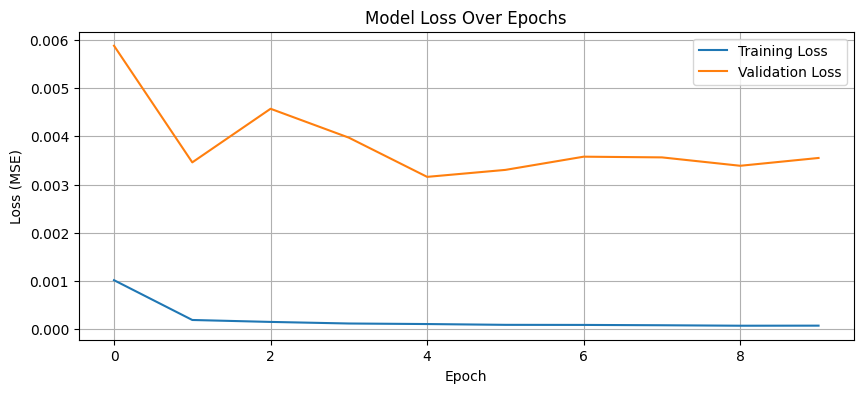

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
model_multi_dani8_5_total      | MAE: 16.943  MSE: 1082.970  RMSE: 32.909  R²:  0.543
model_multi_dani8_5_War        | MAE: 38.922  MSE: 3004.909  RMSE: 54.817  R²:  0.065
model_multi_dani8_5_PostWar    | MAE:  4.951  MSE: 34.430  RMSE:  5.868  R²:  0.306


In [ ]:
#@title model_multi_dani8_5_2023 with 7 features for 30 days horizon prediction
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_dani8_5 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_dani8_5.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_dani8_5 = model_multi_dani8_5.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi_dani8_5)

#@title Evaluate the model_multi_dani8_5 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi_dani8_5.predict(X_test)

# Inverse just the price component
y_pred_multi_dani8_5 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=7)
y_test_multi_dani8_5 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=7)

evaluation_metrics(y_test_multi_dani8_5, y_pred_multi_dani8_5, label = 'model_multi_dani8_5_total', cutoff_date = '2021-12-31', results_df = results_df2, features = ['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30'])



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_multi_dani8_5)]

y_pred_series = pd.Series(y_pred_multi_dani8_5, index=forecast_dates)
y_test_series = pd.Series(y_test_multi_dani8_5, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi_dani8_5_War', cutoff_date = '2021-12-31', results_df=results_df2, features = ['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30']
)

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi_dani8_5_PostWar', cutoff_date = '2021-12-31', results_df=results_df2, features = ['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30'])

In [ ]:
# Calculate forecast dates based on the test set
# The first forecast date corresponds to the end of the first window in the test set
# The last forecast date corresponds to the end of the last window in the test set
forecast_dates = df_selected_features.index[window_size - 1 : -(horizon_days)]
forecast_dates = forecast_dates[split_idx + 1 - buffer:]

save_path = '/content/drive/My Drive/BKW/reports'

# import kaleido

fig = plot_lstm_forecast_aligned_to_forecast_date(
    df_all=df_selected_features,
    forecast_dates=forecast_dates,
    y_pred_inv=y_pred_multi_dani8_5,
    y_true_inv=y_test_multi_dani8_5,
    horizon_days=horizon_days,
    title='TTF Price Forecast (Aligned to Forecast Date) by model_multi_dani8_5_2021',
    # save_path=save_path # Commented out to prevent image export error
)

# Compute metrics
mae_war = mean_absolute_error(y_test_series[war_mask], y_pred_series[war_mask])
r2_war = r2_score(y_test_series[war_mask], y_pred_series[war_mask])

mae_postwar = mean_absolute_error(y_test_series[postwar_mask], y_pred_series[postwar_mask])
r2_postwar = r2_score(y_test_series[postwar_mask], y_pred_series[postwar_mask])


# Add shaded boxes
fig.add_shape(
    type="rect",
    x0="2022-01-01", x1="2023-03-31",
    y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else y_test_series.min(),
    y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else y_test_series.max(),
    fillcolor="LightSalmon",
    opacity=0.2,
    layer="below",
    line_width=0,
)

fig.add_shape(
    type="rect",
    x0="2023-04-01", x1=forecast_dates[-1],
    y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else y_test_series.min(),
    y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else y_test_series.max(),
    fillcolor="LightGreen",
    opacity=0.2,
    layer="below",
    line_width=0,
)

# Add annotations
fig.add_annotation(
    text=f"War Period<br>MAE: {mae_war:.2f}<br>R²: {r2_war:.2f}",
    x="2022-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightSalmon",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

fig.add_annotation(
    text=f"Post-War Period<br>MAE: {mae_postwar:.2f}<br>R²: {r2_postwar:.2f}",
    x="2024-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightGreen",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)
fig.show()

# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "TTF Price Forecast (Aligned to Forecast Date) by model_multi_dani8_5_2021"))

In [ ]:
save_model_and_history(model_multi_dani8_5,
                       history_multi_dani8_5,
                       save_dir='/content/drive/My Drive/BKW/Models',
                       model_name='TTF_lstm_model__multi_dani8_5')

✅ Model saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5_history.pkl


In [ ]:
# load the model
model_loaded, history_loaded = load_model_and_history('/content/drive/My Drive/BKW/Models', model_name='TTF_lstm_model__multi_dani8_5')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5.keras
✅ History loaded from: /content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5_history.pkl


In [ ]:
save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred_multi_dani8_5,
    y_test_multi_dani8_5,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5_forecast.csv'
)

✅ Forecast results saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5_forecast.csv


TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2009-08-03       8.85          9.00         12.05  -0.190302         0.277277   
2009-08-04       9.45          9.45         12.25  -0.106805         0.251534   
2009-08-05       9.25          9.37         12.19  -0.128728         0.216164   
2009-08-06       9.25          9.58         12.46  -0.131727         0.193384   
2009-08-07       9.23          9.57         12.46  -0.136576         0.163787   
...               ...           ...           ...        ...              ...   
2025-07-08      40.03         34.58         34.81   0.161974         0.178367   
2025-07-09      40.03         34.38         34.90   0.151942         0.162929   
2025-07-10      40.03         35.20         35.51   0.142083         0.136029   
2025-07-11      40.03         35.61         35.38   0.132390         0.115302   
2025-07-12      40.03         35.61         35.38   0.130791         0.091395   

            z_score_30  rolling_std_30 Predicted_30D Actual_30D  
Date                                                             
2009-08-03   -0.620677        0.028780          <NA>       <NA>  
2009-08-04    0.422668        0.031702          <NA>       <NA>  
2009-08-05    0.194741        0.031793          <NA>       <NA>  
2009-08-06    0.301744        0.031021          <NA>       <NA>  
2009-08-07    0.407091        0.031000          <NA>       <NA>  
...                ...             ...           ...        ...  
2025-07-08    0.538490        0.018543          <NA>       <NA>  
2025-07-09    0.489161        0.018477          <NA>       <NA>  
2025-07-10    0.448216        0.017889          <NA>       <NA>  
2025-07-11    0.399446        0.017223          <NA>       <NA>  
2025-07-12    0.350465        0.017232          <NA>       <NA>  

[5823 rows x 9 columns]

In [ ]:
df = pd.read_csv('/content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5_forecast.csv')
df.tail(31)

Date  TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  \
5792  2025-06-12  35.900000     36.380000     36.350000   0.054848   
5793  2025-06-13  37.630000     38.190000     38.440000   0.097085   
5794  2025-06-14  37.596667     37.943333     38.340000   0.097713   
5795  2025-06-15  37.563333     37.696667     38.240000   0.054261   
5796  2025-06-16  37.530000     37.450000     38.140000   0.064681   
5797  2025-06-17  39.450000     39.600000     38.900000   0.125342   
5798  2025-06-18  39.400000     39.850000     40.070000   0.130170   
5799  2025-06-19  41.500000     40.280000     40.950000   0.197069   
5800  2025-06-20  40.030000     40.650000     41.200000   0.161165   
5801  2025-06-21  40.030000     40.846667     41.433333   0.167736   
5802  2025-06-22  40.030000     41.043333     41.666667   0.169784   
5803  2025-06-23  40.030000     41.240000     41.900000   0.186074   
5804  2025-06-24  40.030000     35.900000     36.690000   0.218569   
5805  2025-06-25  40.030000     35.380000     35.900000   0.229800   
5806  2025-06-26  40.030000     33.800000     34.470000   0.241240   
5807  2025-06-27  40.030000     32.900000     33.450000   0.252895   
5808  2025-06-28  40.030000     32.800000     33.310000   0.271601   
5809  2025-06-29  40.030000     32.700000     33.170000   0.254859   
5810  2025-06-30  40.030000     32.600000     33.030000   0.251720   
5811  2025-07-01  40.030000     33.440000     34.400000   0.196712   
5812  2025-07-02  40.030000     33.650000     34.210000   0.203307   
5813  2025-07-03  40.030000     33.750000     34.330000   0.209975   
5814  2025-07-04  40.030000     33.400000     34.010000   0.216717   
5815  2025-07-05  40.030000     33.636667     34.173333   0.149297   
5816  2025-07-06  40.030000     33.873333     34.336667   0.171495   
5817  2025-07-07  40.030000     34.110000     34.500000   0.130791   
5818  2025-07-08  40.030000     34.580000     34.810000   0.161974   
5819  2025-07-09  40.030000     34.380000     34.900000   0.151942   
5820  2025-07-10  40.030000     35.200000     35.510000   0.142083   
5821  2025-07-11  40.030000     35.610000     35.380000   0.132390   
5822  2025-07-12  40.030000     35.610000     35.380000   0.130791   

      bollinger_width  z_score_30  rolling_std_30  Predicted_30D  Actual_30D  
5792         0.107761    0.403445        0.023298      34.993471       40.03  
5793         0.113365    1.991054        0.024244            NaN         NaN  
5794         0.119095    1.776246        0.024160            NaN         NaN  
5795         0.123643    1.599467        0.024168            NaN         NaN  
5796         0.127170    1.449314        0.024175            NaN         NaN  
5797         0.144631    2.631076        0.025745            NaN         NaN  
5798         0.157935    2.264494        0.025758            NaN         NaN  
5799         0.188104    3.053121        0.023740            NaN         NaN  
5800         0.201863    1.965723        0.023311            NaN         NaN  
5801         0.213596    1.785274        0.023306            NaN         NaN  
5802         0.223785    1.637612        0.023315            NaN         NaN  
5803         0.232690    1.513307        0.023324            NaN         NaN  
5804         0.240521    1.406515        0.023332            NaN         NaN  
5805         0.247439    1.313281        0.023340            NaN         NaN  
5806         0.253574    1.230829        0.023348            NaN         NaN  
5807         0.258407    1.152568        0.023212            NaN         NaN  
5808         0.258595    1.077269        0.021959            NaN         NaN  
5809         0.248370    1.019726        0.019689            NaN         NaN  
5810         0.238533    0.963438        0.019686            NaN         NaN  
5811         0.229232    0.908019        0.019675            NaN         NaN  
5812         0.220606    0.853215        0.019657            NaN         NaN  
5813         0.215926    0.796740

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5823 entries, 0 to 5822
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             5823 non-null   object 
 1   TTF_Price        5823 non-null   float64
 2   TTFMc1_Close     5823 non-null   float64
 3   TTFMc2_Close     5823 non-null   float64
 4   return_60        5823 non-null   float64
 5   bollinger_width  5823 non-null   float64
 6   z_score_30       5823 non-null   float64
 7   rolling_std_30   5823 non-null   float64
 8   Predicted_30D    1289 non-null   float64
 9   Actual_30D       1289 non-null   float64
dtypes: float64(9), object(1)
memory usage: 455.1+ KB


In [ ]:
#@title Use the model to predict based on the lastest available data
# --- Load CSV ---
csv_path = '/content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5_forecast.csv'  # 🔁 UPDATE this
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Config ---
feature_cols = ['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                'return_60', 'bollinger_width', 'z_score_30', 'rolling_std_30']
window_size = 365
horizon = 30
target_feature_index = 0

# --- Add column if missing ---
if 'Predicted_30D' not in df.columns:
    df['Predicted_30D'] = np.nan

# --- Fit scaler on entire dataset ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load model ---
model_path = '/content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5.keras'  # 🔁 UPDATE this
model = load_model(model_path)

# Loop from 2025-06-13 to 2025-07-12 (inclusive)
start_forecast_idx = df.index.get_loc('2025-06-13')
end_forecast_idx = df.index.get_loc('2025-07-12')  # go all the way

for i in range(start_forecast_idx, end_forecast_idx + 1):
    t = df.index[i]

    # make sure we have 365 days of history
    if i - window_size + 1 < 0:
        continue

    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # forecast TTF_Price at t + 30
    pred_scaled = model.predict(X_input, verbose=0)
    fake_input = np.zeros((1, len(feature_cols)))
    fake_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(fake_input)[0][target_feature_index]

    # store the prediction in the row for date `t`
    df.loc[t, 'Predicted_30D'] = pred_unscaled

df.tail(31)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2025-06-12  35.900000     36.380000     36.350000   0.054848         0.107761   
2025-06-13  37.630000     38.190000     38.440000   0.097085         0.113365   
2025-06-14  37.596667     37.943333     38.340000   0.097713         0.119095   
2025-06-15  37.563333     37.696667     38.240000   0.054261         0.123643   
2025-06-16  37.530000     37.450000     38.140000   0.064681         0.127170   
2025-06-17  39.450000     39.600000     38.900000   0.125342         0.144631   
2025-06-18  39.400000     39.850000     40.070000   0.130170         0.157935   
2025-06-19  41.500000     40.280000     40.950000   0.197069         0.188104   
2025-06-20  40.030000     40.650000     41.200000   0.161165         0.201863   
2025-06-21  40.030000     40.846667     41.433333   0.167736         0.213596   
2025-06-22  40.030000     41.043333     41.666667   0.169784         0.223785   
2025-06-23  40.030000     41.240000     41.900000   0.186074         0.232690   
2025-06-24  40.030000     35.900000     36.690000   0.218569         0.240521   
2025-06-25  40.030000     35.380000     35.900000   0.229800         0.247439   
2025-06-26  40.030000     33.800000     34.470000   0.241240         0.253574   
2025-06-27  40.030000     32.900000     33.450000   0.252895         0.258407   
2025-06-28  40.030000     32.800000     33.310000   0.271601         0.258595   
2025-06-29  40.030000     32.700000     33.170000   0.254859         0.248370   
2025-06-30  40.030000     32.600000     33.030000   0.251720         0.238533   
2025-07-01  40.030000     33.440000     34.400000   0.196712         0.229232   
2025-07-02  40.030000     33.650000     34.210000   0.203307         0.220606   
2025-07-03  40.030000     33.750000     34.330000   0.209975         0.215926   
2025-07-04  40.030000     33.400000     34.010000   0.216717         0.209331   
2025-07-05  40.030000     33.636667     34.173333   0.149297         0.205583   
2025-07-06  40.030000     33.873333     34.336667   0.171495         0.199033   
2025-07-07  40.030000     34.110000     34.500000   0.130791         0.190134   
2025-07-08  40.030000     34.580000     34.810000   0.161974         0.178367   
2025-07-09  40.030000     34.380000     34.900000   0.151942         0.162929   
2025-07-10  40.030000     35.200000     35.510000   0.142083         0.136029   
2025-07-11  40.030000     35.610000     35.380000   0.132390         0.115302   
2025-07-12  40.030000     35.610000     35.380000   0.130791         0.091395   

            z_score_30  rolling_std_30  Predicted_30D  Actual_30D  
Date                                                               
2025-06-12    0.403445        0.023298      34.993471       40.03  
2025-06-13    1.991054        0.024244      35.346325         NaN  
2025-06-14    1.776246        0.024160      35.763460         NaN  
2025-06-15    1.599467        0.024168      36.137728         NaN  
2025-06-16    1.449314        0.024175      36.432328         NaN  
2025-06-17    2.631076        0.025745      36.823153         NaN  
2025-06-18    2.264494        0.025758      37.205921         NaN  
2025-06-19    3.053121        0.023740      37.636666         NaN  
2025-06-20    1.965723        0.023311      37.950580         NaN  
2025-06-21    1.785274        0.023306      38.169306         NaN  
2025-06-22    1.637612        0.023315      38.332316         NaN  
2025-06-23    1.513307        0.023324      38.464944         NaN  
2025-06-24    1.406515        0.023332      38.452376         NaN  
2025-06-25    1.313281        0.023340      38.328117         NaN  
2025-06-26    1.230829        0.023348      38.100087         NaN  
2025-06-27    1.152568        0.023212      37.789285         NaN  
2025-06-28    1.077269        0.021959      37.431740         NaN  
2025-06-29    1.019726        0.019689      37

In [ ]:
# Save to CSV
# df.to_csv('/content/drive/My Drive/BKW/reports/predictions_TTF_LSTM_model_dani8_5.csv')

In [ ]:
# load the csv file
df = pd.read_csv('/content/drive/My Drive/BKW/reports/predictions_TTF_LSTM_model_dani8_5.csv', index_col=0, parse_dates=True)
df.tail(31)

TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2025-06-12  35.900000     36.380000     36.350000   0.054848         0.107761   
2025-06-13  37.630000     38.190000     38.440000   0.097085         0.113365   
2025-06-14  37.596667     37.943333     38.340000   0.097713         0.119095   
2025-06-15  37.563333     37.696667     38.240000   0.054261         0.123643   
2025-06-16  37.530000     37.450000     38.140000   0.064681         0.127170   
2025-06-17  39.450000     39.600000     38.900000   0.125342         0.144631   
2025-06-18  39.400000     39.850000     40.070000   0.130170         0.157935   
2025-06-19  41.500000     40.280000     40.950000   0.197069         0.188104   
2025-06-20  40.030000     40.650000     41.200000   0.161165         0.201863   
2025-06-21  40.030000     40.846667     41.433333   0.167736         0.213596   
2025-06-22  40.030000     41.043333     41.666667   0.169784         0.223785   
2025-06-23  40.030000     41.240000     41.900000   0.186074         0.232690   
2025-06-24  40.030000     35.900000     36.690000   0.218569         0.240521   
2025-06-25  40.030000     35.380000     35.900000   0.229800         0.247439   
2025-06-26  40.030000     33.800000     34.470000   0.241240         0.253574   
2025-06-27  40.030000     32.900000     33.450000   0.252895         0.258407   
2025-06-28  40.030000     32.800000     33.310000   0.271601         0.258595   
2025-06-29  40.030000     32.700000     33.170000   0.254859         0.248370   
2025-06-30  40.030000     32.600000     33.030000   0.251720         0.238533   
2025-07-01  40.030000     33.440000     34.400000   0.196712         0.229232   
2025-07-02  40.030000     33.650000     34.210000   0.203307         0.220606   
2025-07-03  40.030000     33.750000     34.330000   0.209975         0.215926   
2025-07-04  40.030000     33.400000     34.010000   0.216717         0.209331   
2025-07-05  40.030000     33.636667     34.173333   0.149297         0.205583   
2025-07-06  40.030000     33.873333     34.336667   0.171495         0.199033   
2025-07-07  40.030000     34.110000     34.500000   0.130791         0.190134   
2025-07-08  40.030000     34.580000     34.810000   0.161974         0.178367   
2025-07-09  40.030000     34.380000     34.900000   0.151942         0.162929   
2025-07-10  40.030000     35.200000     35.510000   0.142083         0.136029   
2025-07-11  40.030000     35.610000     35.380000   0.132390         0.115302   
2025-07-12  40.030000     35.610000     35.380000   0.130791         0.091395   

            z_score_30  rolling_std_30  Predicted_30D  Actual_30D  
Date                                                               
2025-06-12    0.403445        0.023298      34.993471       40.03  
2025-06-13    1.991054        0.024244      35.346325         NaN  
2025-06-14    1.776246        0.024160      35.763460         NaN  
2025-06-15    1.599467        0.024168      36.137728         NaN  
2025-06-16    1.449314        0.024175      36.432328         NaN  
2025-06-17    2.631076        0.025745      36.823153         NaN  
2025-06-18    2.264494        0.025758      37.205921         NaN  
2025-06-19    3.053121        0.023740      37.636666         NaN  
2025-06-20    1.965723        0.023311      37.950580         NaN  
2025-06-21    1.785274        0.023306      38.169306         NaN  
2025-06-22    1.637612        0.023315      38.332316         NaN  
2025-06-23    1.513307        0.023324      38.464944         NaN  
2025-06-24    1.406515        0.023332      38.452376         NaN  
2025-06-25    1.313281        0.023340      38.328117         NaN  
2025-06-26    1.230829        0.023348      38.100087         NaN  
2025-06-27    1.152568        0.023212      37.789285         NaN  
2025-06-28    1.077269        0.021959      37.431740         NaN  
2025-06-29    1.019726        0.019689      37

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5823 entries, 2009-08-03 to 2025-07-12
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TTF_Price        5823 non-null   float64
 1   TTFMc1_Close     5823 non-null   float64
 2   TTFMc2_Close     5823 non-null   float64
 3   return_60        5823 non-null   float64
 4   bollinger_width  5823 non-null   float64
 5   z_score_30       5823 non-null   float64
 6   rolling_std_30   5823 non-null   float64
 7   Predicted_30D    1319 non-null   float64
 8   Actual_30D       1289 non-null   float64
dtypes: float64(9)
memory usage: 454.9 KB


In [ ]:
df['Year_Week'] = df.index.to_series().dt.strftime('%Y-W%U')
df['Year_Month'] = df.index.to_series().dt.to_period('M').astype(str)
df.tail(41)

TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2025-06-02  34.600000     34.970000     35.150000  -0.126263         0.130417   
2025-06-03  35.580000     36.000000     35.990000  -0.031046         0.122431   
2025-06-04  35.450000     35.350000     35.870000  -0.030007         0.111372   
2025-06-05  36.250000     36.500000     36.650000  -0.003391         0.112252   
2025-06-06  35.880000     36.270000     36.350000  -0.008840         0.109471   
2025-06-07  35.696667     36.033333     36.206667   0.003279         0.109567   
2025-06-08  35.513333     35.796667     36.063333   0.053496         0.107382   
2025-06-09  35.330000     35.560000     35.920000   0.054627         0.106248   
2025-06-10  34.600000     34.780000     35.100000   0.032836         0.107527   
2025-06-11  35.670000     35.800000     36.150000   0.056367         0.107518   
2025-06-12  35.900000     36.380000     36.350000   0.054848         0.107761   
2025-06-13  37.630000     38.190000     38.440000   0.097085         0.113365   
2025-06-14  37.596667     37.943333     38.340000   0.097713         0.119095   
2025-06-15  37.563333     37.696667     38.240000   0.054261         0.123643   
2025-06-16  37.530000     37.450000     38.140000   0.064681         0.127170   
2025-06-17  39.450000     39.600000     38.900000   0.125342         0.144631   
2025-06-18  39.400000     39.850000     40.070000   0.130170         0.157935   
2025-06-19  41.500000     40.280000     40.950000   0.197069         0.188104   
2025-06-20  40.030000     40.650000     41.200000   0.161165         0.201863   
2025-06-21  40.030000     40.846667     41.433333   0.167736         0.213596   
2025-06-22  40.030000     41.043333     41.666667   0.169784         0.223785   
2025-06-23  40.030000     41.240000     41.900000   0.186074         0.232690   
2025-06-24  40.030000     35.900000     36.690000   0.218569         0.240521   
2025-06-25  40.030000     35.380000     35.900000   0.229800         0.247439   
2025-06-26  40.030000     33.800000     34.470000   0.241240         0.253574   
2025-06-27  40.030000     32.900000     33.450000   0.252895         0.258407   
2025-06-28  40.030000     32.800000     33.310000   0.271601         0.258595   
2025-06-29  40.030000     32.700000     33.170000   0.254859         0.248370   
2025-06-30  40.030000     32.600000     33.030000   0.251720         0.238533   
2025-07-01  40.030000     33.440000     34.400000   0.196712         0.229232   
2025-07-02  40.030000     33.650000     34.210000   0.203307         0.220606   
2025-07-03  40.030000     33.750000     34.330000   0.209975         0.215926   
2025-07-04  40.030000     33.400000     34.010000   0.216717         0.209331   
2025-07-05  40.030000     33.636667     34.173333   0.149297         0.205583   
2025-07-06  40.030000     33.873333     34.336667   0.171495         0.199033   
2025-07-07  40.030000     34.110000     34.500000   0.130791         0.190134   
2025-07-08  40.030000     34.580000     34.810000   0.161974         0.178367   
2025-07-09  40.030000     34.380000     34.900000   0.151942         0.162929   
2025-07-10  40.030000     35.200000     35.510000   0.142083         0.136029   
2025-07-11  40.030000     35.610000     35.380000   0.132390         0.115302   
2025-07-12  40.030000     35.610000     35.380000   0.130791         0.091395   

            z_score_30  rolling_std_30  Predicted_30D  Actual_30D Year_Week  \
Date                                                                          
2025-06-02   -0.492317        0.025494      34.355511       40.03  2025-W22   
2025-06-03    0.308044        0.025912      34.363407       40.03  2025-W22   
2025-06-04    0.119269        0.025894      34.438092       40.03  2025-W22   
2025-06-05    0.876247        0.023977      34.633641       40.03  2025-W22   
2025-06-06    0.456782        0.023770      34.820373 

In [ ]:
weekly_df = df.groupby('Year_Week').agg({
    'Predicted_30D': 'mean',
    'Actual_30D': 'mean',
})

In [ ]:
Monthly_df = df.groupby('Year_Month').agg({
    'Predicted_30D': 'mean',
    'Actual_30D': 'mean'
})
Monthly_df.dropna(inplace=True)
Monthly_df

Predicted_30D  Actual_30D
Year_Month                           
2021-12         94.237315   84.209667
2022-01         78.088870   84.463548
2022-02         73.117830  129.757500
2022-03        101.464823  101.630726
2022-04         91.761418   88.733750
2022-05         87.151075  105.172742
2022-06         86.373113  169.786111
2022-07        129.615732  237.182151
2022-08        165.336046  189.974194
2022-09        167.508834   75.926667
2022-10        119.648471   94.051613
2022-11         85.896968  114.449000
2022-12        104.355609   63.807097
2023-01         64.769166   53.174516
2023-02         51.502066   43.994286
2023-03         43.289909   42.794677
2023-04         41.281165   31.585000
2023-05         33.046312   31.775484
2023-06         28.903419   29.739667
2023-07         29.694563   33.324194
2023-08         32.802696   36.316559
2023-09         36.573995   43.710556
2023-10         42.123130   43.233548
2023-11         44.428138   35.502667
2023-12         36.950087   29.830000
2024-01         30.018378   25.743548
2024-02         26.061549   26.815862
2024-03         26.500695   28.961613
2024-04         28.659407   31.713333
2024-05         30.820275   34.241613
2024-06         33.895716   32.053667
2024-07         32.794238   37.751935
2024-08         36.572926   36.375484
2024-09         36.244787   40.169000
2024-10         39.046564   44.233333
2024-11         42.095547   44.926722
2024-12         43.628188   48.400323
2025-01         45.930627   50.559677
2025-02         48.981817   41.387500
2025-03         40.997659   35.087097
2025-04         35.399113   35.036000
2025-05         34.205607   37.723226
2025-06         36.302246   40.030000

In [ ]:
# Define date range
start_date = '2023-04-01'
end_date = '2025-06-12'

daily_filtered = df.loc[start_date:end_date]
# Compute metrics
mae_daily = (daily_filtered['Predicted_30D'] - daily_filtered['Actual_30D']).abs().mean()
mape_daily = ((daily_filtered['Predicted_30D'] - daily_filtered['Actual_30D']).abs() / daily_filtered['Actual_30D']).mean() * 100

print(f"Daily MAE (Apr 1, 2023 – Jun 12, 2023): {mae_daily:.2f}")
print(f"Daily MAE MAPE (Apr 1, 2023 – Jun 12, 2023): {mape_daily:.2f}%")

Daily MAE (Apr 1, 2023 – Jun 12, 2023): 4.81
Daily MAE MAPE (Apr 1, 2023 – Jun 12, 2023): 13.55%


In [ ]:
# Convert Year_Week to datetime (week starting Monday)
weekly_df = weekly_df.copy()
weekly_df['Week_Start'] = pd.to_datetime(weekly_df.index + '-1', format='%Y-W%W-%w')
weekly_df.set_index('Week_Start', inplace=True)


weekly_filtered = weekly_df.loc[start_date:end_date]

# Compute metrics
mae_weekly = (weekly_filtered['Predicted_30D'] - weekly_filtered['Actual_30D']).abs().mean()
mape_weekly = ((weekly_filtered['Predicted_30D'] - weekly_filtered['Actual_30D']).abs() / weekly_filtered['Actual_30D']).mean() * 100

print(f"Weekly MAE (Apr 1, 2023 – Jun 12, 2023): {mae_weekly:.2f}")
print(f"Weekly MAPE (Apr 1, 2023 – Jun 12, 2023): {mape_weekly:.2f}%")

Weekly MAE (Apr 1, 2023 – Jun 12, 2023): 4.71
Weekly MAPE (Apr 1, 2023 – Jun 12, 2023): 13.22%


In [ ]:
# Convert Year_Month (e.g., '2023-06') to datetime
Monthly_df = Monthly_df.copy()
Monthly_df['Month_Start'] = pd.to_datetime(Monthly_df.index, format='%Y-%m')
Monthly_df.set_index('Month_Start', inplace=True)


# Filter and compute metrics
Monthly_filtered = Monthly_df.loc[start_date:end_date]

mae_monthly = (Monthly_filtered['Predicted_30D'] - Monthly_filtered['Actual_30D']).abs().mean()
mape_monthly = ((Monthly_filtered['Predicted_30D'] - Monthly_filtered['Actual_30D']).abs() / Monthly_filtered['Actual_30D']).mean() * 100

print(f"Monthly MAE (Apr 1, 2023 – Jun 12, 2023): {mae_monthly:.2f}")
print(f"Monthly MAPE (Apr 1, 2023 – Jun 12, 2023): {mape_monthly:.2f}%")

Monthly MAE (Apr 1, 2023 – Jun 12, 2023): 3.95
Monthly MAPE (Apr 1, 2023 – Jun 12, 2023): 10.91%


In [ ]:
df_plot = df.copy()

# Set the forecast horizon
horizon_days = 30
cutoff_date = "2021-12-31"
features = ['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                'return_60', 'bollinger_width', 'z_score_30', 'rolling_std_30']
# Add shaded boxes
# Step 2: Determine y-range
ymin = min(df_plot['TTF_Price'].min(), df_plot['Predicted_30D'].min(), df_plot['Actual_30D'].min())
ymax = max(df_plot['TTF_Price'].max(), df_plot['Predicted_30D'].max(), df_plot['Actual_30D'].max())

# Start building the plot
fig = go.Figure()

# Historical TTF price
fig.add_trace(go.Scatter(
x=df_plot.index,
y=df_plot['TTF_Price'],
mode='lines',
name='Historical Price',
line=dict(color='lightgray'),
opacity=0.5
))

# Predicted target prices (plotted on forecast date)
fig.add_trace(go.Scatter(
x=df_plot.index,
y=df_plot['Predicted_30D'].values,
mode='lines+markers',
name=f'Predicted price (+{horizon_days}D)',
marker=dict(size=2.5),
line=dict(color='orange')
))

# Actual future prices aligned to forecast date
fig.add_trace(go.Scatter(
x=df_plot.index,
y=df_plot['Actual_30D'].values,
mode='lines+markers',
name=f'Actual price (+{horizon_days}D)',
marker=dict(size=2.5),
line=dict(color='blue')
))

# Add shaded boxes
# Step 2: Determine y-range
ymin = min(df_plot['TTF_Price'].min(), df_plot['Predicted_30D'].min(), df_plot['Actual_30D'].min())
ymax = max(df_plot['TTF_Price'].max(), df_plot['Predicted_30D'].max(), df_plot['Actual_30D'].max())

# Step 3: Add shaded boxes
fig.add_shape(
    type="rect",
    x0="2022-01-01", x1="2023-03-31",
    y0=ymin,
    y1=ymax,
    fillcolor="LightSalmon",
    opacity=0.2,
    layer="below",
    line_width=0,
)

fig.add_shape(
    type="rect",
    x0="2023-04-01", x1=df_plot.index.max(),
    y0=ymin,
    y1=ymax,
    fillcolor="LightGreen",
    opacity=0.2,
    layer="below",
    line_width=0,
)


# Step 4: Add annotations (example metrics)
PostWar_mae_daily = mae_daily
PostWar_mae_monthly = mae_monthly
PostWar_mae_weekly = mae_weekly
PostWar_mape_daily = mape_daily
PostWar_mape_monthly = mape_monthly
PostWar_mape_weekly = mape_weekly



fig.add_annotation(
    text=f"Post-War Period: <br>Daily MAE: {PostWar_mae_daily:.2f}<br>Weekly MAE: {PostWar_mae_weekly:.2f}<br>Monthly MAE: {PostWar_mae_monthly:.2f}",
    x="2024-07-01",
    y=150,
    showarrow=False,
    bgcolor="LightGreen",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

# Add vertical line for cutoff
fig.add_shape(
    type="line",
    x0=cutoff_date, x1=cutoff_date,
    y0=ymin-15, y1=ymax+20,
    line=dict(color="black", width=2),
    name="Cutoff"
)

# Add annotation arrows to show training and test regions
fig.add_annotation(
    x="2016-12-31",  # adjust position to left of cutoff
    y=ymax+10,
    axref='x', ayref='y',
    ax="2020-12-01", ay=ymax+10,
    showarrow=True,
    arrowhead=3,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="gray",
    text="Training Data",
    font=dict(size=14),
    bgcolor="white"
)

fig.add_annotation(
    x="2024-05-01",  # adjust position to right of cutoff
    y=ymax+10,
    axref='x', ayref='y',
    ax="2022-10-31", ay=ymax+10,
    showarrow=True,
    arrowhead=3,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="gray",
    text="Test Data",
    font=dict(size=14),
    bgcolor="white"
)

fig.add_annotation(
    text=f'Features: {features}',
    xref="paper", yref="paper",
    x=1, y=1.08,                # slightly above the plot
    showarrow=False,
    font=dict(size=12, color="gray"),
    xanchor='right'
)


# Layout
fig.update_layout(
title=f'TTF Forecast: Prediction vs Actual (+{horizon_days}D)',
xaxis_title='Forecast Date (when the prediction was made)',
yaxis_title='TTF_Price (EUR/MWh)',
hovermode='x unified',
xaxis=dict(tickangle=-45),
height=600
)

fig.show()


# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "TTF Price Forecast (Aligned to Forecast Date) by TTF_lstm_model__multi_dani8_5_2021_adding_agg_MAE"))

In [ ]:
# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "TTF Price Forecast (Aligned to Forecast Date) by model_multi_dani8_5_2021"))

# Some other exploratorary models

*   model_multi_dani8_5_2023 with 7 features but moving train_test cutoff_date to 2023-03-31 model performance dropped dramatically
*   model_multi_top4 with 'TTF_Price', 'TTFMc2_Close','bollinger_width', 'TTFMc1_Close' shows almost equal performance like the dani8_5 with 7 features




X_train shape: (4595, 365, 7)
X_test shape: (834, 365, 7)
y_train shape: (4595,)
y_test shape: (834,)
Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0014 - mae: 0.0245 - mape: 475.1086 - rmse: 0.0364 - val_loss: 0.0417 - val_mae: 0.1553 - val_mape: 67.3741 - val_rmse: 0.2042 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 3.9210e-04 - mae: 0.0129 - mape: 470.0349 - rmse: 0.0198 - val_loss: 0.0462 - val_mae: 0.1625 - val_mape: 72.0686 - val_rmse: 0.2149 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 3.7014e-04 - mae: 0.0114 - mape: 592.5332 - rmse: 0.0192 - val_loss: 0.0399 - val_mae: 0.1481 - val_mape: 63.0918 - val_rmse: 0.1998 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 3.3052e-04 - mae: 0.0102 - mape: 54.8343 - rmse: 0.0182 - val_loss: 0.0648 - val_mae: 0.1841 - val_mape: 82.9111 - val_rmse: 0.2546 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━━━━━━━━━

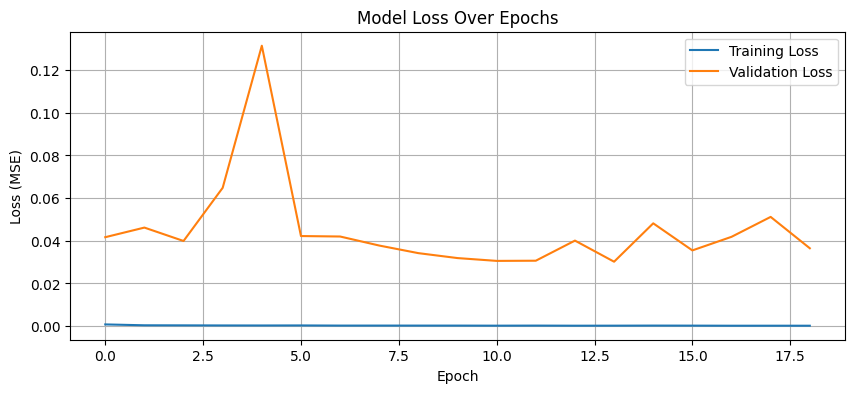

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
model_multi_dani8_5_2023       | MAE:  6.542  MSE: 74.736  RMSE:  8.645  R²: -0.506


Label        MAE          MSE       RMSE        R2  \
0    model_multi_dani8_5_total  16.635475  1060.231094  32.561190  0.552687   
1      model_multi_dani8_5_War  38.387559  2942.920635  54.248692  0.084384   
2  model_multi_dani8_5_PostWar   4.768330    33.104306   5.753634  0.333091   
3     model_multi_dani8_5_2023   6.542003    74.735555   8.644973 -0.505599   

  cutoff_date                                           features  
0  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
1  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
2  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
3  2023-03-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...

In [ ]:
#@title model_multi_dani8_5_2023 with 7 features but moving train_test cutoff_date to 2023-03-31
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2023-03-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_dani8_5_2023 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_dani8_5_2023.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_dani8_5_2023 = model_multi_dani8_5_2023.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi_dani8_5_2023)

#@title Evaluate the model_multi_dani8_5_2023 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi_dani8_5_2023.predict(X_test)

# Inverse just the price component
y_pred_multi_dani8_5_2023 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=7)
y_test_multi_dani8_5_2023 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=7)

evaluation_metrics(y_test_multi_dani8_5_2023, y_pred_multi_dani8_5_2023, label = 'model_multi_dani8_5_2023', cutoff_date = '2023-03-31', results_df = results_df, features = ['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30'])



X_train shape: (4140, 365, 4)
X_test shape: (1289, 365, 4)
y_train shape: (4140,)
y_test shape: (1289,)
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 4.1308e-04 - mae: 0.0139 - mape: 898.2385 - rmse: 0.0193 - val_loss: 0.0031 - val_mae: 0.0334 - val_mape: 22.4771 - val_rmse: 0.0559 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.2543e-05 - mae: 0.0069 - mape: 6607.2192 - rmse: 0.0096 - val_loss: 0.0037 - val_mae: 0.0376 - val_mape: 25.2554 - val_rmse: 0.0611 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 9.9007e-05 - mae: 0.0067 - mape: 4158.2139 - rmse: 0.0099 - val_loss: 0.0034 - val_mae: 0.0357 - val_mape: 24.6118 - val_rmse: 0.0582 - learning_rate: 0.0010
Epoch 4/50
116/117 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6921e-05 - mae: 0.0060 - mape: 16261.9902 - rmse: 0.0082
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - 

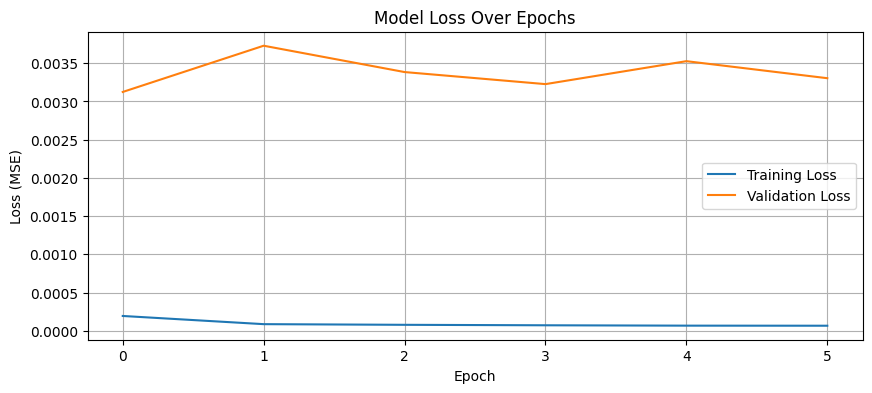

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
model_multi_top4_total         | MAE: 16.641  MSE: 1051.548  RMSE: 32.428  R²:  0.556
model_multi_top4_War           | MAE: 38.332  MSE: 2917.366  RMSE: 54.013  R²:  0.092
model_multi_top4_PostWar       | MAE:  4.807  MSE: 33.626  RMSE:  5.799  R²:  0.323


In [ ]:
#@title model_multi_top4 with 'TTF_Price', 'TTFMc2_Close','bollinger_width', 'TTFMc1_Close'

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['TTF_Price', 'TTFMc2_Close','bollinger_width', 'TTFMc1_Close']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_top4 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.2),
    LSTM(16),                            # Second LSTM layer outputs a vector
    Dropout(0.1),
    Dense(1)                             # Predict a single target value
])

model_multi_top4.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_model_multi_top4 = model_multi_top4.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_model_multi_top4)

#@title Evaluate the model_multi_top4 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi_top4.predict(X_test)

# Inverse just the price component
y_pred_model_multi_top4 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=4)
y_test_model_multi_top4 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=4)

evaluation_metrics(y_test_model_multi_top4, y_pred_model_multi_top4, label = 'model_multi_top4_total', cutoff_date = '2021-12-31', results_df = results_df, features = ['TTF_Price', 'TTFMc2_Close','bollinger_width', 'TTFMc1_Close'])



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_model_multi_top4)]

y_pred_series = pd.Series(y_pred_model_multi_top4, index=forecast_dates)
y_test_series = pd.Series(y_test_model_multi_top4, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi_top4_War', cutoff_date = cutoff_date, results_df=results_df2, features = features.columns.tolist()
)

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi_top4_PostWar', cutoff_date = cutoff_date, results_df=results_df2, features = features.columns.tolist())

In [ ]:
save_model_and_history(model_multi_top4,
                       history_model_multi_top4,
                       save_dir='/content/drive/My Drive/BKW/Models',
                       model_name='TTF_lstm_model_multi_top4')

✅ Model saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model_multi_top4.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model_multi_top4_history.pkl


In [ ]:
# Calculate forecast dates based on the test set
# The first forecast date corresponds to the end of the first window in the test set
# The last forecast date corresponds to the end of the last window in the test set
forecast_dates = df_selected_features.index[window_size - 1 : -(horizon_days)]
forecast_dates = forecast_dates[split_idx + 1 - buffer:]

save_path = '/content/drive/My Drive/BKW/reports'

# import kaleido

fig = plot_lstm_forecast_aligned_to_forecast_date(
    df_all=df_selected_features,
    forecast_dates=forecast_dates,
    y_pred_inv=y_pred_model_multi_top4,
    y_true_inv=y_test_model_multi_top4,
    horizon_days=horizon_days,
    title='TTF Price Forecast (Aligned to Forecast Date) by model_multi_dani8_5_2021',
    # save_path=save_path # Commented out to prevent image export error
)

# Compute metrics
mae_war = mean_absolute_error(y_test_series[war_mask], y_pred_series[war_mask])
r2_war = r2_score(y_test_series[war_mask], y_pred_series[war_mask])

mae_postwar = mean_absolute_error(y_test_series[postwar_mask], y_pred_series[postwar_mask])
r2_postwar = r2_score(y_test_series[postwar_mask], y_pred_series[postwar_mask])


# Add shaded boxes
fig.add_shape(
    type="rect",
    x0="2022-01-01", x1="2023-03-31",
    y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else y_test_series.min(),
    y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else y_test_series.max(),
    fillcolor="LightSalmon",
    opacity=0.2,
    layer="below",
    line_width=0,
)

fig.add_shape(
    type="rect",
    x0="2023-04-01", x1=forecast_dates[-1],
    y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else y_test_series.min(),
    y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else y_test_series.max(),
    fillcolor="LightGreen",
    opacity=0.2,
    layer="below",
    line_width=0,
)

# Add annotations
fig.add_annotation(
    text=f"War Period<br>MAE: {mae_war:.2f}<br>R²: {r2_war:.2f}",
    x="2022-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightSalmon",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

fig.add_annotation(
    text=f"Post-War Period<br>MAE: {mae_postwar:.2f}<br>R²: {r2_postwar:.2f}",
    x="2024-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightGreen",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)
fig.show()

# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "TTF Price Forecast (Aligned to Forecast Date) by model_top4_2021"))

# Run GridSearch based on Model_multi_Dani8_5

In [ ]:
from tensorflow.keras import backend as K

#Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30']]
scaled = scaler.fit_transform(features)
cutoff_date = '2021-12-31'

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

# Hyperparameter grid
window_sizes = [30, 90, 180, 365]
horizon_days_list = [30, 60, 90]
lstm_units_list = [(32, 16), (64, 32)]
dropout_configs = [(0.2, 0.1), (0.4, 0.2), (0.5, 0.3)]  # (first LSTM, second LSTM)

experiment_results = []

for window_size in tqdm(window_sizes, desc='Window Sizes', position=0):
    for horizon_days in tqdm(horizon_days_list, desc=f'Horizons for window {window_size}', leave=False):
        print(f'\n🔁 Training: window={window_size}, horizon={horizon_days}')
        for (lstm1, lstm2) in lstm_units_list:
            for (drop1, drop2) in dropout_configs:
                print(f'\n🔁 Training: window={window_size}, horizon={horizon_days}, LSTM=({lstm1},{lstm2}), Dropout=({drop1},{drop2})')

                # Reset graph/session
                K.clear_session()

                # Recompute split and buffer
                buffer = window_size + horizon_days - 1
                split_idx = df_selected_features.index.get_loc(cutoff_date)
                scaled_train = scaled[:split_idx + 1]
                scaled_test = scaled[split_idx + 1 - buffer:]

                # Generate sequences
                X_train, y_train = create_sequences_multifeature(scaled_train, window_size, horizon_days)
                X_test, y_test = create_sequences_multifeature(scaled_test, window_size, horizon_days)

                # Train/Val split
                val_size = int(len(X_train) * 0.1)
                X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
                y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

                # Build model
                model = Sequential([
                    Input(shape=(X_train.shape[1], X_train.shape[2])),
                    LSTM(lstm1, return_sequences=True),
                    Dropout(drop1),
                    LSTM(lstm2),
                    Dropout(drop2),
                    Dense(1)
                ])
                model.compile(
                    optimizer=Adam(),
                    loss='mse',
                    metrics=[
                        MeanAbsoluteError(name='mae'),
                        RootMeanSquaredError(name='rmse'),
                        MeanAbsolutePercentageError(name='mape')
                    ]
                )

                # Train model
                history = model.fit(
                    X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
                    verbose=0
                )

                # Predict
                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred_inv = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
                y_test_inv = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

                # Evaluate
                mae = mean_absolute_error(y_test_inv, y_pred_inv)
                mse = mean_squared_error(y_test_inv, y_pred_inv)
                rmse = np.sqrt(mse) # Calculate RMSE manually
                mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
                r2 = r2_score(y_test_inv, y_pred_inv)

                experiment_results.append({
                    'window_size': window_size,
                    'horizon_days': horizon_days,
                    'lstm1': lstm1,
                    'lstm2': lstm2,
                    'drop1': drop1,
                    'drop2': drop2,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'R2': r2
                })

# Convert to DataFrame
results_df = pd.DataFrame(experiment_results)

Horizons for window 30:   0%|          | 0/3 [00:00<?, ?it/s]


🔁 Training: window=30, horizon=30

🔁 Training: window=30, horizon=30, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=30, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=30, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=30, horizon=30, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=30, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=30, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 30:  33%|███▎      | 1/3 [01:45<03:31, 105.55s/it]


🔁 Training: window=30, horizon=60

🔁 Training: window=30, horizon=60, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=60, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=60, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=30, horizon=60, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=60, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=60, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 30:  67%|██████▋   | 2/3 [03:46<01:54, 114.62s/it]


🔁 Training: window=30, horizon=90

🔁 Training: window=30, horizon=90, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=90, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=90, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=30, horizon=90, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=90, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=90, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 90:   0%|          | 0/3 [00:00<?, ?it/s]


🔁 Training: window=90, horizon=30

🔁 Training: window=90, horizon=30, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=30, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=30, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=90, horizon=30, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=30, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=30, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 90:  33%|███▎      | 1/3 [02:34<05:08, 154.47s/it]


🔁 Training: window=90, horizon=60

🔁 Training: window=90, horizon=60, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=60, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=60, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=90, horizon=60, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=60, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=60, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 90:  67%|██████▋   | 2/3 [04:29<02:11, 131.19s/it]


🔁 Training: window=90, horizon=90

🔁 Training: window=90, horizon=90, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=90, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=90, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=90, horizon=90, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=90, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=90, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 180:   0%|          | 0/3 [00:00<?, ?it/s]


🔁 Training: window=180, horizon=30

🔁 Training: window=180, horizon=30, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=30, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=30, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=180, horizon=30, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=30, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=30, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 180:  33%|███▎      | 1/3 [03:29<06:58, 209.31s/it]


🔁 Training: window=180, horizon=60

🔁 Training: window=180, horizon=60, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=60, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=60, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=180, horizon=60, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=60, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=60, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 180:  67%|██████▋   | 2/3 [06:20<03:06, 186.78s/it]


🔁 Training: window=180, horizon=90

🔁 Training: window=180, horizon=90, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=90, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=90, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=180, horizon=90, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=90, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=90, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 365:   0%|          | 0/3 [00:00<?, ?it/s]


🔁 Training: window=365, horizon=30

🔁 Training: window=365, horizon=30, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=30, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=30, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=365, horizon=30, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=30, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=30, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 365:  33%|███▎      | 1/3 [04:14<08:28, 254.01s/it]


🔁 Training: window=365, horizon=60

🔁 Training: window=365, horizon=60, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=60, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=60, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=365, horizon=60, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=60, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=60, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 365:  67%|██████▋   | 2/3 [08:34<04:18, 258.03s/it]


🔁 Training: window=365, horizon=90

🔁 Training: window=365, horizon=90, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=90, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=90, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=365, horizon=90, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=90, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=90, LSTM=(64,32), Dropout=(0.5,0.3)



Window Sizes: 100%|██████████| 4/4 [34:13<00:00, 513.41s/it]


In [ ]:
# results_df.to_csv('/content/drive/My Drive/BKW/Models/gridsearch_TTF_LSTM_model_dani8_5_results.csv')
results_df = pd.read_csv('/content/drive/My Drive/BKW/Models/gridsearch_TTF_LSTM_model_dani8_5_results.csv', index_col='Unnamed: 0')
results_df.head()

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
0           30            30     32     16    0.2    0.1  16.582217   
1           30            30     32     16    0.4    0.2  16.654245   
2           30            30     32     16    0.5    0.3  16.653553   
3           30            30     64     32    0.2    0.1  17.333812   
4           30            30     64     32    0.4    0.2  16.548779   

        rmse       mape        R2  
0  32.453414  22.329905  0.555644  
1  32.677684  21.873318  0.549481  
2  33.598321  20.781992  0.523738  
3  33.079244  24.351895  0.538340  
4  32.454717  22.441867  0.555608

In [ ]:
results_df.sort_values(by='R2', ascending=False).head(10)

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
57          365            30     64     32    0.2    0.1  16.617771   
0            30            30     32     16    0.2    0.1  16.582217   
4            30            30     64     32    0.4    0.2  16.548779   
18           90            30     32     16    0.2    0.1  16.566769   
22           90            30     64     32    0.4    0.2  16.634064   
59          365            30     64     32    0.5    0.3  16.518320   
55          365            30     32     16    0.4    0.2  16.622550   
1            30            30     32     16    0.4    0.2  16.654245   
39          180            30     64     32    0.2    0.1  16.959073   
23           90            30     64     32    0.5    0.3  16.541761   

         rmse       mape        R2  
57  32.430695  22.709430  0.556265  
0   32.453414  22.329905  0.555644  
4   32.454717  22.441867  0.555608  
18  32.495850  22.069260  0.554481  
22  32.571437  22.807261  0.552406  
59  32.606827  21.946599  0.551433  
55  32.634581  22.042227  0.550669  
1   32.677684  21.873318  0.549481  
39  32.711810  23.486831  0.548539  
23  32.804469  21.980405  0.545978

In [ ]:
best_rows = results_df.sort_values(by='R2', ascending=False).drop_duplicates('horizon_days')
best_rows

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
57          365            30     64     32    0.2    0.1  16.617771   
61          365            60     32     16    0.4    0.2  20.117619   
48          180            90     32     16    0.2    0.1  23.324424   

         rmse       mape        R2  
57  32.430695  22.709430  0.556265  
61  38.651149  27.618112  0.369717  
48  41.050095  33.139478  0.289050

In [ ]:
best_by_horizon_60 = results_df[results_df['horizon_days'] == 60].sort_values(by='R2', ascending=False).head(5)
best_by_horizon_60

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
61          365            60     32     16    0.4    0.2  20.117619   
42          180            60     32     16    0.2    0.1  20.224460   
62          365            60     32     16    0.5    0.3  20.160752   
44          180            60     32     16    0.5    0.3  20.357164   
65          365            60     64     32    0.5    0.3  20.621402   

         rmse       mape        R2  
61  38.651149  27.618112  0.369717  
42  38.721612  27.582754  0.367417  
62  38.774031  27.550554  0.365703  
44  38.886891  27.642677  0.362005  
65  38.958066  29.539594  0.359668

In [ ]:
best_by_horizon_90 = results_df[results_df['horizon_days'] == 90].sort_values(by='R2', ascending=False).head(5)
best_by_horizon_90

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
48          180            90     32     16    0.2    0.1  23.324424   
32           90            90     32     16    0.5    0.3  23.533640   
67          365            90     32     16    0.4    0.2  23.553903   
13           30            90     32     16    0.4    0.2  22.705860   
50          180            90     32     16    0.5    0.3  23.170477   

         rmse       mape        R2  
48  41.050095  33.139478  0.289050  
32  41.100006  34.087439  0.287320  
67  41.404909  33.183484  0.276707  
13  41.535105  31.034933  0.272151  
50  41.546486  31.861410  0.271752

# Run GridSearch based on Model_multi_top4 features

In [ ]:
from tensorflow.keras import backend as K

#Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['TTF_Price', 'TTFMc2_Close','bollinger_width', 'TTFMc1_Close']]
scaled = scaler.fit_transform(features)
cutoff_date = '2021-12-31'

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

# Hyperparameter grid
window_sizes = [30, 90, 180, 365]
horizon_days_list = [30, 60, 90]
lstm_units_list = [(32, 16), (64, 32)]
dropout_configs = [(0.2, 0.1), (0.4, 0.2), (0.5, 0.3)]  # (first LSTM, second LSTM)

experiment_results_top4 = []

for window_size in tqdm(window_sizes, desc='Window Sizes', position=0):
    for horizon_days in tqdm(horizon_days_list, desc=f'Horizons for window {window_size}', leave=False):
        print(f'\n🔁 Training: window={window_size}, horizon={horizon_days}')
        for (lstm1, lstm2) in lstm_units_list:
            for (drop1, drop2) in dropout_configs:
                print(f'\n🔁 Training: window={window_size}, horizon={horizon_days}, LSTM=({lstm1},{lstm2}), Dropout=({drop1},{drop2})')

                # Reset graph/session
                K.clear_session()

                # Recompute split and buffer
                buffer = window_size + horizon_days - 1
                split_idx = df_selected_features.index.get_loc(cutoff_date)
                scaled_train = scaled[:split_idx + 1]
                scaled_test = scaled[split_idx + 1 - buffer:]

                # Generate sequences
                X_train, y_train = create_sequences_multifeature(scaled_train, window_size, horizon_days)
                X_test, y_test = create_sequences_multifeature(scaled_test, window_size, horizon_days)

                # Train/Val split
                val_size = int(len(X_train) * 0.1)
                X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
                y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

                # Build model
                model = Sequential([
                    Input(shape=(X_train.shape[1], X_train.shape[2])),
                    LSTM(lstm1, return_sequences=True),
                    Dropout(drop1),
                    LSTM(lstm2),
                    Dropout(drop2),
                    Dense(1)
                ])
                model.compile(
                    optimizer=Adam(),
                    loss='mse',
                    metrics=[
                        MeanAbsoluteError(name='mae'),
                        RootMeanSquaredError(name='rmse'),
                        MeanAbsolutePercentageError(name='mape')
                    ]
                )

                # Train model
                history = model.fit(
                    X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
                    verbose=0
                )

                # Predict
                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred_inv = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
                y_test_inv = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

                # Evaluate
                mae = mean_absolute_error(y_test_inv, y_pred_inv)
                mse = mean_squared_error(y_test_inv, y_pred_inv)
                rmse = np.sqrt(mse) # Calculate RMSE manually
                mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
                r2 = r2_score(y_test_inv, y_pred_inv)

                experiment_results_top4.append({
                    'window_size': window_size,
                    'horizon_days': horizon_days,
                    'lstm1': lstm1,
                    'lstm2': lstm2,
                    'drop1': drop1,
                    'drop2': drop2,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'R2': r2
                })

# Convert to DataFrame
results_df_top4 = pd.DataFrame(experiment_results_top4)

Horizons for window 30:   0%|          | 0/3 [00:00<?, ?it/s]


🔁 Training: window=30, horizon=30

🔁 Training: window=30, horizon=30, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=30, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=30, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=30, horizon=30, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=30, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=30, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 30:  33%|███▎      | 1/3 [01:42<03:24, 102.40s/it]


🔁 Training: window=30, horizon=60

🔁 Training: window=30, horizon=60, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=60, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=60, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=30, horizon=60, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=60, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=60, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 30:  67%|██████▋   | 2/3 [03:36<01:48, 108.99s/it]


🔁 Training: window=30, horizon=90

🔁 Training: window=30, horizon=90, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=90, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=90, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=30, horizon=90, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=30, horizon=90, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=30, horizon=90, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 90:   0%|          | 0/3 [00:00<?, ?it/s]


🔁 Training: window=90, horizon=30

🔁 Training: window=90, horizon=30, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=30, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=30, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=90, horizon=30, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=30, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=30, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 90:  33%|███▎      | 1/3 [02:20<04:41, 140.77s/it]


🔁 Training: window=90, horizon=60

🔁 Training: window=90, horizon=60, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=60, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=60, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=90, horizon=60, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=60, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=60, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 90:  67%|██████▋   | 2/3 [04:37<02:18, 138.44s/it]


🔁 Training: window=90, horizon=90

🔁 Training: window=90, horizon=90, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=90, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=90, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=90, horizon=90, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=90, horizon=90, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=90, horizon=90, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 180:   0%|          | 0/3 [00:00<?, ?it/s]


🔁 Training: window=180, horizon=30

🔁 Training: window=180, horizon=30, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=30, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=30, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=180, horizon=30, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=30, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=30, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 180:  33%|███▎      | 1/3 [02:41<05:23, 161.78s/it]


🔁 Training: window=180, horizon=60

🔁 Training: window=180, horizon=60, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=60, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=60, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=180, horizon=60, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=60, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=60, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 180:  67%|██████▋   | 2/3 [05:50<02:57, 177.80s/it]


🔁 Training: window=180, horizon=90

🔁 Training: window=180, horizon=90, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=90, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=90, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=180, horizon=90, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=180, horizon=90, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=180, horizon=90, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 365:   0%|          | 0/3 [00:00<?, ?it/s]


🔁 Training: window=365, horizon=30

🔁 Training: window=365, horizon=30, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=30, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=30, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=365, horizon=30, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=30, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=30, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 365:  33%|███▎      | 1/3 [04:27<08:55, 267.58s/it]


🔁 Training: window=365, horizon=60

🔁 Training: window=365, horizon=60, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=60, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=60, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=365, horizon=60, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=60, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=60, LSTM=(64,32), Dropout=(0.5,0.3)



Horizons for window 365:  67%|██████▋   | 2/3 [08:55<04:27, 267.68s/it]


🔁 Training: window=365, horizon=90

🔁 Training: window=365, horizon=90, LSTM=(32,16), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=90, LSTM=(32,16), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=90, LSTM=(32,16), Dropout=(0.5,0.3)

🔁 Training: window=365, horizon=90, LSTM=(64,32), Dropout=(0.2,0.1)

🔁 Training: window=365, horizon=90, LSTM=(64,32), Dropout=(0.4,0.2)

🔁 Training: window=365, horizon=90, LSTM=(64,32), Dropout=(0.5,0.3)



Window Sizes: 100%|██████████| 4/4 [35:35<00:00, 533.80s/it]


In [ ]:
results_df_top4

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
0            30            30     32     16    0.2    0.1  16.956835   
1            30            30     32     16    0.4    0.2  16.756332   
2            30            30     32     16    0.5    0.3  17.395348   
3            30            30     64     32    0.2    0.1  16.867075   
4            30            30     64     32    0.4    0.2  17.802624   
..          ...           ...    ...    ...    ...    ...        ...   
67          365            90     32     16    0.4    0.2  24.988968   
68          365            90     32     16    0.5    0.3  25.111422   
69          365            90     64     32    0.2    0.1  26.667869   
70          365            90     64     32    0.4    0.2  25.957428   
71          365            90     64     32    0.5    0.3  25.071184   

         rmse       mape        R2  
0   32.547433  23.488992  0.553065  
1   32.621426  22.856925  0.551031  
2   33.141302  24.570411  0.536607  
3   32.394288  23.352697  0.557261  
4   33.874236  25.220705  0.515884  
..        ...        ...       ...  
67  42.784449  35.977755  0.227706  
68  42.987378  36.102105  0.220363  
69  45.457721  39.171245  0.128182  
70  44.500440  37.251138  0.164514  
71  43.055529  36.973435  0.217889  

[72 rows x 10 columns]

In [ ]:
# results_df_top4.to_csv('/content/drive/My Drive/BKW/Models/gridsearch_TTF_LSTM_model_top4.csv')
results_df_top4 = pd.read_csv('/content/drive/My Drive/BKW/Models/gridsearch_TTF_LSTM_model_top4.csv', index_col='Unnamed: 0')
results_df_top4.head()

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
0           30            30     32     16    0.2    0.1  16.956835   
1           30            30     32     16    0.4    0.2  16.756332   
2           30            30     32     16    0.5    0.3  17.395348   
3           30            30     64     32    0.2    0.1  16.867075   
4           30            30     64     32    0.4    0.2  17.802624   

        rmse       mape        R2  
0  32.547433  23.488992  0.553065  
1  32.621426  22.856925  0.551031  
2  33.141302  24.570411  0.536607  
3  32.394288  23.352697  0.557261  
4  33.874236  25.220705  0.515884

In [ ]:
best_rows = results_df_top4.sort_values(by='R2', ascending=False).drop_duplicates('horizon_days')
best_rows

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
54          365            30     32     16    0.2    0.1  16.692357   
7            30            60     32     16    0.4    0.2  20.670728   
30           90            90     32     16    0.2    0.1  24.446654   

         rmse       mape        R2  
54  32.192409  23.084530  0.562762  
7   38.892943  29.873090  0.361807  
30  41.963993  35.821758  0.257042

In [ ]:
best_top4_by_horizon_60 = results_df_top4[results_df['horizon_days'] == 60].sort_values(by='R2', ascending=False).head(5)
best_top4_by_horizon_60

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
7            30            60     32     16    0.4    0.2  20.670728   
8            30            60     32     16    0.5    0.3  20.717340   
44          180            60     32     16    0.5    0.3  20.955944   
61          365            60     32     16    0.4    0.2  20.664968   
6            30            60     32     16    0.2    0.1  20.982925   

         rmse       mape        R2  
7   38.892943  29.873090  0.361807  
8   38.895246  29.368250  0.361731  
44  39.307526  30.118947  0.348128  
61  39.313011  29.671598  0.347946  
6   39.508332  30.848735  0.341451

In [ ]:
best_top4_by_horizon_90 = results_df_top4[results_df['horizon_days'] == 90].sort_values(by='R2', ascending=False).head(5)
best_top4_by_horizon_90

window_size  horizon_days  lstm1  lstm2  drop1  drop2        mae  \
30           90            90     32     16    0.2    0.1  24.446654   
53          180            90     64     32    0.5    0.3  24.308670   
34           90            90     64     32    0.4    0.2  24.523507   
35           90            90     64     32    0.5    0.3  24.539192   
12           30            90     32     16    0.2    0.1  24.892405   

         rmse       mape        R2  
30  41.963993  35.821758  0.257042  
53  42.131701  34.876823  0.251092  
34  42.437093  35.064882  0.240195  
35  42.526964  34.922721  0.236974  
12  42.544116  36.184720  0.236358

X_train shape: (4110, 365, 7)
X_test shape: (1289, 365, 7)
y_train shape: (4110,)
y_test shape: (1289,)
Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 9.4416e-04 - mae: 0.0227 - mape: 214.2959 - rmse: 0.0299 - val_loss: 0.0076 - val_mae: 0.0592 - val_mape: 37.0071 - val_rmse: 0.0872 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.1039e-04 - mae: 0.0111 - mape: 13474.5713 - rmse: 0.0145 - val_loss: 0.0058 - val_mae: 0.0517 - val_mape: 32.8155 - val_rmse: 0.0764 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.4391e-04 - mae: 0.0094 - mape: 2919.6982 - rmse: 0.0120 - val_loss: 0.0052 - val_mae: 0.0489 - val_mape: 32.0239 - val_rmse: 0.0719 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 1.3038e-04 - mae: 0.0087 - mape: 6978.5063 - rmse: 0.0114 - val_loss: 0.0048 - val_mae: 0.0467 - val_mape: 30.9829 - val_rmse: 0.0693 - learning_rate: 0.0010
Epoch 5/50
116/116 ━

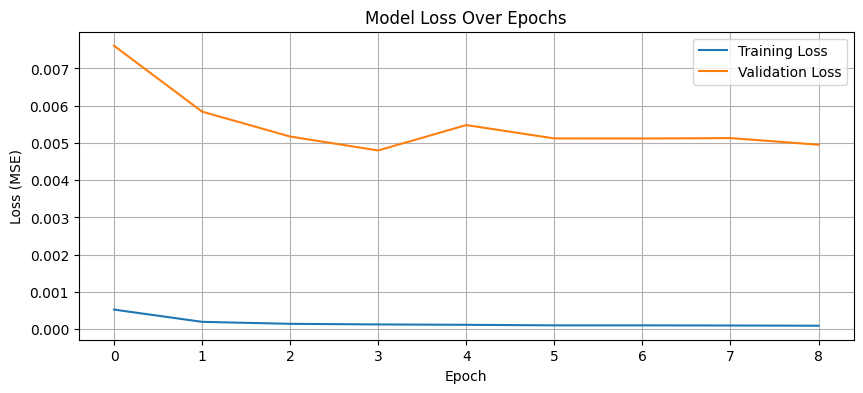

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
model_multi_dani8_5_2021_60_total | MAE: 20.793  MSE: 1565.774  RMSE: 39.570  R²:  0.339
model_multi_dani8_5_2021_60_War | MAE: 46.658  MSE: 4323.386  RMSE: 65.752  R²: -0.345
model_multi_dani8_5_2021_60_PostWar | MAE:  6.681  MSE: 61.321  RMSE:  7.831  R²: -0.235


In [ ]:
#@title model_multi_dani8_5_2021_60 with 7 features for 60 days horizon prediction
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 60
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_dani8_5_2021_60 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(16),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_dani8_5_2021_60.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_dani8_5_2021_60 = model_multi_dani8_5_2021_60.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi_dani8_5_2021_60)

#@title Evaluate the model_multi_dani8_5_2021_60 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi_dani8_5_2021_60.predict(X_test)

# Inverse just the price component
y_pred_multi_dani8_5_2021_60 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi_dani8_5_2021_60 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_multi_dani8_5_2021_60, y_pred_multi_dani8_5_2021_60, label = 'model_multi_dani8_5_2021_60_total', cutoff_date = cutoff_date, results_df = results_df2, features = features.columns.tolist())




In [ ]:

# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_multi_dani8_5_2021_60)]





y_pred_series = pd.Series(y_pred_multi_dani8_5_2021_60, index=forecast_dates)
y_test_series = pd.Series(y_test_multi_dani8_5_2021_60, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi_dani8_5_2021_60_War', cutoff_date = cutoff_date, results_df=results_df2, features = features.columns.tolist()
)

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi_dani8_5_2021_60_PostWar', cutoff_date = cutoff_date, results_df=results_df2, features = features.columns.tolist())

model_multi_dani8_5_2021_60_War | MAE: 45.485  MSE: 4293.253  RMSE: 65.523  R²: -0.140
model_multi_dani8_5_2021_60_PostWar | MAE:  6.799  MSE: 63.279  RMSE:  7.955  R²: -0.267


In [ ]:
save_model_and_history(model_multi_dani8_5_2021_60,
                       history_multi_dani8_5_2021_60,
                       save_dir='/content/drive/My Drive/BKW/Models',
                       model_name='TTF_lstm_model_multi_dani8_5_2021_60')

✅ Model saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model_multi_dani8_5_2021_60.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model_multi_dani8_5_2021_60_history.pkl


In [ ]:
forecast_dates = df_selected_features.index[window_size - 1 : -(horizon_days)]
forecast_dates = forecast_dates[split_idx + 1 - buffer:]
# Step 2: Plot the aligned forecast
fig = plot_lstm_forecast_aligned_to_forecast_date(
    df_all=df_selected_features,
    forecast_dates=forecast_dates,
    y_pred_inv=y_pred_multi_dani8_5_2021_60,
    y_true_inv=y_test_multi_dani8_5_2021_60,
    horizon_days=horizon_days,
    title='TTF Price Forecast (Aligned to Forecast Date) by model_multi_dani8_5_2021_60'
)

# Step 3: Metrics for war and post-war
mae_war = mean_absolute_error(y_test_series[war_mask], y_pred_series[war_mask])
r2_war = r2_score(y_test_series[war_mask], y_pred_series[war_mask])
mae_postwar = mean_absolute_error(y_test_series[postwar_mask], y_pred_series[postwar_mask])
r2_postwar = r2_score(y_test_series[postwar_mask], y_pred_series[postwar_mask])

# Step 4: Shaded regions
fig.add_shape(
    type="rect",
    x0="2022-01-01", x1="2023-03-31",
    y0=y_test_series.min(),
    y1=y_test_series.max(),
    fillcolor="LightSalmon",
    opacity=0.2,
    layer="below",
    line_width=0,
)

fig.add_shape(
    type="rect",
    x0="2023-04-01", x1=forecast_dates[-1],
    y0=y_test_series.min(),
    y1=y_test_series.max(),
    fillcolor="LightGreen",
    opacity=0.2,
    layer="below",
    line_width=0,
)

# Step 5: Add annotations
fig.add_annotation(
    text=f"War Period<br>MAE: {mae_war:.2f}<br>R²: {r2_war:.2f}",
    x="2022-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightSalmon",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

fig.add_annotation(
    text=f"Post-War Period<br>MAE: {mae_postwar:.2f}<br>R²: {r2_postwar:.2f}",
    x="2024-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightGreen",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

# Step 6: Show and optionally save
fig.show()

# Optional save
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "TTF_Price_Forecast_model_multi_dani8_5_2021_60.html"))

In [ ]:
save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred_multi_dani8_5_2021_60,
    y_test_multi_dani8_5_2021_60,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5__2021_60_forecast.csv'
)

✅ Forecast results saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model__multi_dani8_5__2021_60_forecast.csv


TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2009-08-03       8.85          9.00         12.05  -0.190302         0.277277   
2009-08-04       9.45          9.45         12.25  -0.106805         0.251534   
2009-08-05       9.25          9.37         12.19  -0.128728         0.216164   
2009-08-06       9.25          9.58         12.46  -0.131727         0.193384   
2009-08-07       9.23          9.57         12.46  -0.136576         0.163787   
...               ...           ...           ...        ...              ...   
2025-07-08      40.03         34.58         34.81   0.161974         0.178367   
2025-07-09      40.03         34.38         34.90   0.151942         0.162929   
2025-07-10      40.03         35.20         35.51   0.142083         0.136029   
2025-07-11      40.03         35.61         35.38   0.132390         0.115302   
2025-07-12      40.03         35.61         35.38   0.130791         0.091395   

            z_score_30  rolling_std_30 Predicted_60D Actual_60D  
Date                                                             
2009-08-03   -0.620677        0.028780          <NA>       <NA>  
2009-08-04    0.422668        0.031702          <NA>       <NA>  
2009-08-05    0.194741        0.031793          <NA>       <NA>  
2009-08-06    0.301744        0.031021          <NA>       <NA>  
2009-08-07    0.407091        0.031000          <NA>       <NA>  
...                ...             ...           ...        ...  
2025-07-08    0.538490        0.018543          <NA>       <NA>  
2025-07-09    0.489161        0.018477          <NA>       <NA>  
2025-07-10    0.448216        0.017889          <NA>       <NA>  
2025-07-11    0.399446        0.017223          <NA>       <NA>  
2025-07-12    0.350465        0.017232          <NA>       <NA>  

[5823 rows x 9 columns]

In [ ]:
forecast_60 = pd.read_csv('/content/drive/My Drive/BKW/reports/TTF_lstm_model__multi_dani8_5__2021_60_forecast.csv', index_col=0)
forecast_60.head()

TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2009-08-03       8.85          9.00         12.05  -0.190302         0.277277   
2009-08-04       9.45          9.45         12.25  -0.106805         0.251534   
2009-08-05       9.25          9.37         12.19  -0.128728         0.216164   
2009-08-06       9.25          9.58         12.46  -0.131727         0.193384   
2009-08-07       9.23          9.57         12.46  -0.136576         0.163787   

            z_score_30  rolling_std_30  Predicted_60D  Actual_60D  
Date                                                               
2009-08-03   -0.620677        0.028780            NaN         NaN  
2009-08-04    0.422668        0.031702            NaN         NaN  
2009-08-05    0.194741        0.031793            NaN         NaN  
2009-08-06    0.301744        0.031021            NaN         NaN  
2009-08-07    0.407091        0.031000            NaN         NaN

In [ ]:
forecast_60.tail()

TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2025-07-08      40.03         34.58         34.81   0.161974         0.178367   
2025-07-09      40.03         34.38         34.90   0.151942         0.162929   
2025-07-10      40.03         35.20         35.51   0.142083         0.136029   
2025-07-11      40.03         35.61         35.38   0.132390         0.115302   
2025-07-12      40.03         35.61         35.38   0.130791         0.091395   

            z_score_30  rolling_std_30  Predicted_60D  Actual_60D  
Date                                                               
2025-07-08    0.538490        0.018543            NaN         NaN  
2025-07-09    0.489161        0.018477            NaN         NaN  
2025-07-10    0.448216        0.017889            NaN         NaN  
2025-07-11    0.399446        0.017223            NaN         NaN  
2025-07-12    0.350465        0.017232            NaN         NaN

In [ ]:
#@title Use the model to predict based on the lastest available data
# --- Load CSV ---
csv_path = '/content/drive/My Drive/BKW/reports/TTF_lstm_model__multi_dani8_5__2021_60_forecast.csv'  # 🔁 UPDATE this
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Config ---
feature_cols = features.columns.tolist()
window_size = window_size
horizon = horizon_days
target_feature_index = 0

# --- Add column if missing ---
if 'Predicted_60D' not in df.columns:
    df['Predicted_60D'] = np.nan

# --- Fit scaler on entire dataset ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load model ---
model_path = '/content/drive/My Drive/BKW/Models/TTF_lstm_model_multi_dani8_5_2021_60.keras'  # 🔁 UPDATE this
model = load_model(model_path)

# Loop from 2025-05-14 to 2025-07-12 (inclusive)
start_forecast_idx = df.index.get_loc('2025-05-14')
end_forecast_idx = df.index.get_loc('2025-07-12')  # go all the way

for i in range(start_forecast_idx, end_forecast_idx + 1):
    t = df.index[i]

    # make sure we have 365 days of history
    if i - window_size + 1 < 0:
        continue

    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # forecast TTF_Price at t + 60
    pred_scaled = model.predict(X_input, verbose=0)
    fake_input = np.zeros((1, len(feature_cols)))
    fake_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(fake_input)[0][target_feature_index]

    # store the prediction in the row for date `t`
    df.loc[t, 'Predicted_60D'] = pred_unscaled

df.tail(61)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMax

TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2025-05-13  35.400000         35.70         35.80  -0.161137         0.144694   
2025-05-14  34.450000         34.75         34.90  -0.175837         0.144894   
2025-05-15  34.950000         35.28         34.70  -0.155797         0.146306   
2025-05-16  35.000000         35.14         35.40  -0.146341         0.143543   
2025-05-17  35.033333         35.16         35.32  -0.130687         0.142695   
...               ...           ...           ...        ...              ...   
2025-07-08  40.030000         34.58         34.81   0.161974         0.178367   
2025-07-09  40.030000         34.38         34.90   0.151942         0.162929   
2025-07-10  40.030000         35.20         35.51   0.142083         0.136029   
2025-07-11  40.030000         35.61         35.38   0.132390         0.115302   
2025-07-12  40.030000         35.61         35.38   0.130791         0.091395   

            z_score_30  rolling_std_30  Predicted_60D  Actual_60D  
Date                                                               
2025-05-13    1.200516        0.020079      31.196956       40.03  
2025-05-14    0.421708        0.020691      31.315584         NaN  
2025-05-15    0.801156        0.020847      31.422044         NaN  
2025-05-16    0.875387        0.019476      31.534907         NaN  
2025-05-17    0.914287        0.019381      31.653864         NaN  
...                ...             ...            ...         ...  
2025-07-08    0.538490        0.018543      34.890499         NaN  
2025-07-09    0.489161        0.018477      34.808042         NaN  
2025-07-10    0.448216        0.017889      34.758984         NaN  
2025-07-11    0.399446        0.017223      34.738128         NaN  
2025-07-12    0.350465        0.017232      34.746005         NaN  

[61 rows x 9 columns]

In [ ]:
df.tail(62)

TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2025-05-12      35.35         35.42         36.19  -0.138855         0.141156   
2025-05-13      35.40         35.70         35.80  -0.161137         0.144694   
2025-05-14      34.45         34.75         34.90  -0.175837         0.144894   
2025-05-15      34.95         35.28         34.70  -0.155797         0.146306   
2025-05-16      35.00         35.14         35.40  -0.146341         0.143543   
...               ...           ...           ...        ...              ...   
2025-07-08      40.03         34.58         34.81   0.161974         0.178367   
2025-07-09      40.03         34.38         34.90   0.151942         0.162929   
2025-07-10      40.03         35.20         35.51   0.142083         0.136029   
2025-07-11      40.03         35.61         35.38   0.132390         0.115302   
2025-07-12      40.03         35.61         35.38   0.130791         0.091395   

            z_score_30  rolling_std_30  Predicted_60D  Actual_60D  
Date                                                               
2025-05-12    1.228546        0.020113      31.000584       40.03  
2025-05-13    1.200516        0.020079      31.196956       40.03  
2025-05-14    0.421708        0.020691      31.315584         NaN  
2025-05-15    0.801156        0.020847      31.422044         NaN  
2025-05-16    0.875387        0.019476      31.534907         NaN  
...                ...             ...            ...         ...  
2025-07-08    0.538490        0.018543      34.890499         NaN  
2025-07-09    0.489161        0.018477      34.808042         NaN  
2025-07-10    0.448216        0.017889      34.758984         NaN  
2025-07-11    0.399446        0.017223      34.738128         NaN  
2025-07-12    0.350465        0.017232      34.746005         NaN  

[62 rows x 9 columns]

In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/60d_prediction_model_multi_dani8_5_2021_60_add_latest_data.csv')

X_train shape: (4265, 180, 7)
X_test shape: (1289, 180, 7)
y_train shape: (4265,)
y_test shape: (1289,)
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0017 - mae: 0.0294 - mape: 9275.5303 - rmse: 0.0396 - val_loss: 0.0112 - val_mae: 0.0680 - val_mape: 40.2801 - val_rmse: 0.1058 - learning_rate: 0.0010
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.3668e-04 - mae: 0.0145 - mape: 16728.1719 - rmse: 0.0183 - val_loss: 0.0090 - val_mae: 0.0636 - val_mape: 42.4988 - val_rmse: 0.0947 - learning_rate: 0.0010
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.2987e-04 - mae: 0.0120 - mape: 1788.0411 - rmse: 0.0152 - val_loss: 0.0085 - val_mae: 0.0614 - val_mape: 40.0459 - val_rmse: 0.0922 - learning_rate: 0.0010
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7125e-04 - mae: 0.0104 - mape: 6415.7412 - rmse: 0.0131 - val_loss: 0.0079 - val_mae: 0.0573 - val_mape: 35.1821 - val_rmse: 0.0887 - learning_rate: 0.0010
Epoch 5/50
120/120 ━━━━

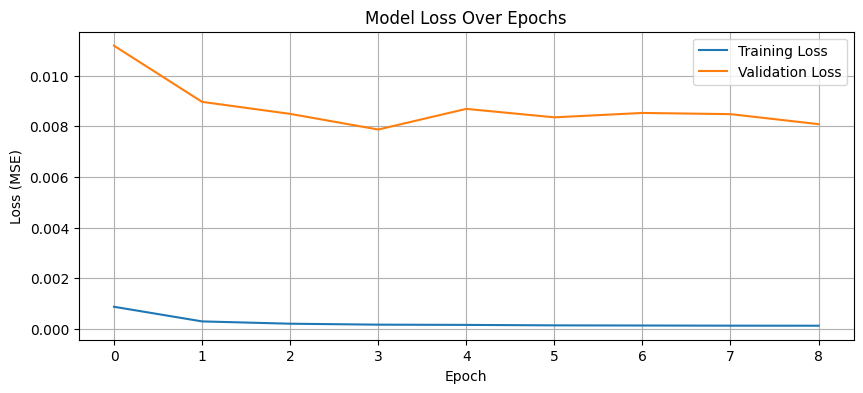

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
model_multi_dani8_5_2021_90_total | MAE: 22.878  MSE: 1748.049  RMSE: 41.810  R²:  0.262
model_multi_dani8_5_2021_90_War | MAE: 45.535  MSE: 4419.606  RMSE: 66.480  R²: -0.133
model_multi_dani8_5_2021_90_PostWar | MAE:  8.172  MSE: 89.831  RMSE:  9.478  R²: -0.798


Label        MAE          MSE       RMSE  \
0    model_multi_dani8_5_2021_60_total  20.310886  1495.237906  38.668306   
1      model_multi_dani8_5_2021_60_War  45.000758  4119.757085  64.185334   
2  model_multi_dani8_5_2021_60_PostWar   6.840991    63.395907   7.962155   
3    model_multi_dani8_5_2021_90_total  22.877927  1748.048892  41.809675   
4      model_multi_dani8_5_2021_90_War  45.535382  4419.605628  66.480115   
5  model_multi_dani8_5_2021_90_PostWar   8.172430    89.831495   9.477948   

         R2 cutoff_date                                           features  
0  0.369157  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
1 -0.281759  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
2 -0.277154  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
3  0.262496  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
4 -0.133475  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
5 -0.798132  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...

In [ ]:
#@title model_multi_dani8_5_2021_90 with 7 features for 90 days horizon prediction
"""
according to the gridsearch results the best model setting for the 90 horizon is
window_size = 180
lstm1 32
lstm2 16
drop1 0.2
drop2 0.1

"""

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
                 'return_60','bollinger_width', 'z_score_30', 'rolling_std_30']]
scaled = scaler.fit_transform(features)


# Define parameters
window_size = 180
horizon_days = 90
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_dani8_5_2021_90 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(16),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_dani8_5_2021_90.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_dani8_5_2021_90 = model_multi_dani8_5_2021_90.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi_dani8_5_2021_90)

#@title Evaluate the model_multi_dani8_5_2021_90 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi_dani8_5_2021_90.predict(X_test)

# Inverse just the price component
y_pred_multi_dani8_5_2021_90 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi_dani8_5_2021_90 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_multi_dani8_5_2021_90, y_pred_multi_dani8_5_2021_90, label = 'model_multi_dani8_5_2021_90_total', cutoff_date = cutoff_date, results_df = results_df2, features = features.columns.tolist())

# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_multi_dani8_5_2021_90)]





y_pred_series = pd.Series(y_pred_multi_dani8_5_2021_90, index=forecast_dates)
y_test_series = pd.Series(y_test_multi_dani8_5_2021_90, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi_dani8_5_2021_90_War', cutoff_date = cutoff_date, results_df=results_df2, features = features.columns.tolist()
)

evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi_dani8_5_2021_90_PostWar', cutoff_date = cutoff_date, results_df=results_df2, features = features.columns.tolist())

In [ ]:
save_model_and_history(model_multi_dani8_5_2021_90,
                       history_multi_dani8_5_2021_90,
                       save_dir='/content/drive/My Drive/BKW/Models',
                       model_name='TTF_lstm_model_multi_dani8_5_2021_90')

✅ Model saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model_multi_dani8_5_2021_90.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/TTF_lstm_model_multi_dani8_5_2021_90_history.pkl


In [ ]:
save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred_multi_dani8_5_2021_90,
    y_test_multi_dani8_5_2021_90,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/TTF_lstm_model__multi_dani8_5__2021_90_forecast.csv'
)

✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/TTF_lstm_model__multi_dani8_5__2021_90_forecast.csv


TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2009-08-03       8.85          9.00         12.05  -0.190302         0.277277   
2009-08-04       9.45          9.45         12.25  -0.106805         0.251534   
2009-08-05       9.25          9.37         12.19  -0.128728         0.216164   
2009-08-06       9.25          9.58         12.46  -0.131727         0.193384   
2009-08-07       9.23          9.57         12.46  -0.136576         0.163787   
...               ...           ...           ...        ...              ...   
2025-07-08      40.03         34.58         34.81   0.161974         0.178367   
2025-07-09      40.03         34.38         34.90   0.151942         0.162929   
2025-07-10      40.03         35.20         35.51   0.142083         0.136029   
2025-07-11      40.03         35.61         35.38   0.132390         0.115302   
2025-07-12      40.03         35.61         35.38   0.130791         0.091395   

            z_score_30  rolling_std_30 Predicted_90D Actual_90D  
Date                                                             
2009-08-03   -0.620677        0.028780          <NA>       <NA>  
2009-08-04    0.422668        0.031702          <NA>       <NA>  
2009-08-05    0.194741        0.031793          <NA>       <NA>  
2009-08-06    0.301744        0.031021          <NA>       <NA>  
2009-08-07    0.407091        0.031000          <NA>       <NA>  
...                ...             ...           ...        ...  
2025-07-08    0.538490        0.018543          <NA>       <NA>  
2025-07-09    0.489161        0.018477          <NA>       <NA>  
2025-07-10    0.448216        0.017889          <NA>       <NA>  
2025-07-11    0.399446        0.017223          <NA>       <NA>  
2025-07-12    0.350465        0.017232          <NA>       <NA>  

[5823 rows x 9 columns]

In [ ]:
#@title Use the model to predict based on the lastest available data
# --- Load CSV ---
csv_path = '/content/drive/My Drive/BKW/reports/TTF_lstm_model__multi_dani8_5__2021_90_forecast.csv'  # 🔁 UPDATE this
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Config ---
feature_cols = features.columns.tolist()
window_size = window_size
horizon = horizon_days
target_feature_index = 0

# --- Add column if missing ---
if 'Predicted_90D' not in df.columns:
    df['Predicted_90D'] = np.nan

# --- Fit scaler on entire dataset ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load model ---
model_path = '/content/drive/My Drive/BKW/Models/TTF_lstm_model_multi_dani8_5_2021_90.keras'  # 🔁 UPDATE this
model = load_model(model_path)

# Loop from 2025-04-14 to 2025-07-12 (inclusive)
start_forecast_idx = df.index.get_loc('2025-04-14')
end_forecast_idx = df.index.get_loc('2025-07-12')  # go all the way

for i in range(start_forecast_idx, end_forecast_idx + 1):
    t = df.index[i]

    # make sure we have 365 days of history
    if i - window_size + 1 < 0:
        continue

    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # forecast TTF_Price at t + 90
    pred_scaled = model.predict(X_input, verbose=0)
    fake_input = np.zeros((1, len(feature_cols)))
    fake_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(fake_input)[0][target_feature_index]

    # store the prediction in the row for date `t`
    df.loc[t, 'Predicted_90D'] = pred_unscaled

df.tail(91)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMax

TTF_Price  TTFMc1_Close  TTFMc2_Close  return_60  bollinger_width  \
Date                                                                            
2025-04-13  34.033333     34.313333         34.44  -0.390630         0.325632   
2025-04-14  34.300000     34.670000         34.76  -0.338221         0.335966   
2025-04-15  34.250000     34.250000         35.15  -0.336240         0.345611   
2025-04-16  35.630000     35.420000         35.60  -0.295618         0.348847   
2025-04-17  35.250000     35.400000         35.50  -0.288837         0.353878   
...               ...           ...           ...        ...              ...   
2025-07-08  40.030000     34.580000         34.81   0.161974         0.178367   
2025-07-09  40.030000     34.380000         34.90   0.151942         0.162929   
2025-07-10  40.030000     35.200000         35.51   0.142083         0.136029   
2025-07-11  40.030000     35.610000         35.38   0.132390         0.115302   
2025-07-12  40.030000     35.610000         35.38   0.130791         0.091395   

            z_score_30  rolling_std_30  Predicted_90D  Actual_90D  
Date                                                               
2025-04-13   -1.612688        0.024564      32.056085       40.03  
2025-04-14   -1.415095        0.024703      31.815655         NaN  
2025-04-15   -1.327738        0.024710      31.567183         NaN  
2025-04-16   -0.857336        0.026099      31.394105         NaN  
2025-04-17   -0.911260        0.026017      31.216701         NaN  
...                ...             ...            ...         ...  
2025-07-08    0.538490        0.018543      34.798901         NaN  
2025-07-09    0.489161        0.018477      34.735688         NaN  
2025-07-10    0.448216        0.017889      34.705165         NaN  
2025-07-11    0.399446        0.017223      34.704400         NaN  
2025-07-12    0.350465        0.017232      34.730168         NaN  

[91 rows x 9 columns]

In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/90d_prediction_model_multi_dani8_5_2021_90_add_latest_data.csv')

Label        MAE          MSE       RMSE  \
0    model_multi_dani8_5_2021_60_total  20.310886  1495.237906  38.668306   
1      model_multi_dani8_5_2021_60_War  45.000758  4119.757085  64.185334   
2  model_multi_dani8_5_2021_60_PostWar   6.840991    63.395907   7.962155   
3    model_multi_dani8_5_2021_90_total  22.877927  1748.048892  41.809675   
4      model_multi_dani8_5_2021_90_War  45.535382  4419.605628  66.480115   
5  model_multi_dani8_5_2021_90_PostWar   8.172430    89.831495   9.477948   

         R2 cutoff_date                                           features  
0  0.369157  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
1 -0.281759  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
2 -0.277154  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
3  0.262496  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
4 -0.133475  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...  
5 -0.798132  2021-12-31  TTF_Price, TTFMc1_Close, TTFMc2_Close, return_...